## Phase locked windows in brain data

In [34]:
import numpy as np
import pandas as pd
import math as m
import random as r
import cvxpy as cp
from scipy.integrate import odeint
import seaborn as sns
import KuramotoFunctionBank as KFB
import GPMAlgorithm as GPM
import importlib
import matplotlib.pyplot as plt
import csv
import cmath
from scipy.signal import butter, lfilter, hilbert, argrelextrema
from scipy.sparse.csgraph import connected_components
from sklearn.cluster import KMeans
importlib.reload(GPM)
importlib.reload(KFB)

<module 'KuramotoFunctionBank' from '/Users/ramon/Desktop/Year 1/kuramotocontrol/KuramotoFunctionBank.py'>

In [2]:
#Same fMRI pre-processing done in the other notebook

N = 66
Subj18Run2 = open('Subject18Run2.txt', 'r')
permutation = open('permutation.txt','r')
reader = csv.reader(Subj18Run2)
reader2 = csv.reader(permutation)
DataAsList = [row for row in reader]
permutation = [x-1 for x in list(map(int, [row.split(',') for row in permutation][0]))]
DataAsArray =[]
for data in DataAsList:
    DataAsArray.append(data[0].split(' '))
for i in range(0,len(DataAsArray)):
    while '' in DataAsArray[i]:
        DataAsArray[i].remove('')
    for j in range(0,len(DataAsArray[i])):
        DataAsArray[i][j]=float(DataAsArray[i][j])
DataAsArray=np.array(DataAsArray)
#Phase-locked region is the same as the one obtained by Basset et al.
#Permute according to parcellation
DataAsArray=DataAsArray[:,permutation]
FilteredSignals =KFB.butter_bandpass_filter(DataAsArray,0.04,0.06,0.5,10)
analytic_signal = hilbert(FilteredSignals,axis=0)
Hilbert = np.zeros((300,N))
for i in range(0,N):
    for t in range(0,300):
        Hilbert[t,i]=m.atan2(analytic_signal[t,i].real,analytic_signal[t,i].imag)

In [3]:
# Phase locking algorithm 
window_length = 30
PLV_index = np.zeros(300-window_length)
for t0 in range(0,300-window_length):
    PLV = KFB.CalculatePhaseLockingValue(Hilbert[t0:t0+window_length,:])
    PLV_index[t0] = KFB.CalculatePhaseLockingIndex(PLV)
local_maxima = argrelextrema(PLV_index,np.greater)[0]


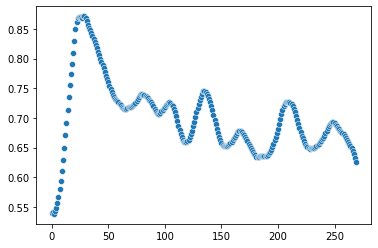

In [4]:
t = np.linspace(0,len(PLV_index),num=len(PLV_index))
sns.scatterplot(PLV_index)
chosen_windows =[]
for locmax in local_maxima:
    if PLV_index[locmax]>0.7:
        chosen_windows.append(locmax)
windows_to_remove =[]
for w in chosen_windows:
    for c in chosen_windows:
        if np.abs(w-c)<window_length & w!=c:
            if PLV_index[w]>PLV_index[c]:
                windows_to_remove.append(c)
chosen_windows = sorted(list(set(chosen_windows) - set(windows_to_remove)))
E = len(chosen_windows)

In [5]:
chosen_windows

[29, 80, 104, 135, 208]

### Now that we have extracted the chosen phase locked windows, we extract a functional pattern for each one

In [5]:
BOLDPhases = np.zeros((window_length,N,E))
BOLDPhases_no_mod = np.zeros((window_length,N,E))

for i in range(0,E):
    t0 = chosen_windows[i]
    BOLDPhases[:,:,i] = Hilbert[t0:t0+window_length,:]
    BOLDPhases_no_mod[:,:,i] = KFB.RemoveBounds(BOLDPhases[:,:,i])

#Complete identical steps to in previous cases to extract R and F matrices for these 2 phase locked states



In [6]:
Average_Cos_Phase_Difference = np.zeros((N,N,E))
SyntheticFC = np.zeros((N,N,E))
x_min_brain = np.zeros((N,E))
EstimatedPhases = np.zeros((N,E))
for w in range(0,E):
    Cos_Phase_Differences = np.zeros((N,N,window_length))
    Phase_Differences = np.zeros((N,N,window_length))
    for i in range(0,window_length):
        for j in range(0,N):
            for k in range(0,N):
                Cos_Phase_Differences[j][k][i] = np.cos(BOLDPhases_no_mod[i][k][w]-BOLDPhases_no_mod[i][j][w])
                Phase_Differences[j][k][i] = BOLDPhases_no_mod[i][k][w]-BOLDPhases_no_mod[i][j][w]
    Average_Cos_Phase_Difference[:,:,w] = np.mean(Cos_Phase_Differences,axis=2)
    Average_Phase_Difference = np.mean(Phase_Differences,axis=2)
    C = KFB.CalculateCFromMeanPhaseDiff(Average_Phase_Difference)
    EstimatedPhases[:,w] = GPM.GPMAlgorithm(C)
    x_min_brain[:,w] = KFB.CalculateXMinFromPhases(EstimatedPhases[:,w])
    SyntheticFC[:,:,w] = KFB.CalculateCorrelationMatrixFromPhases(EstimatedPhases[:,w])

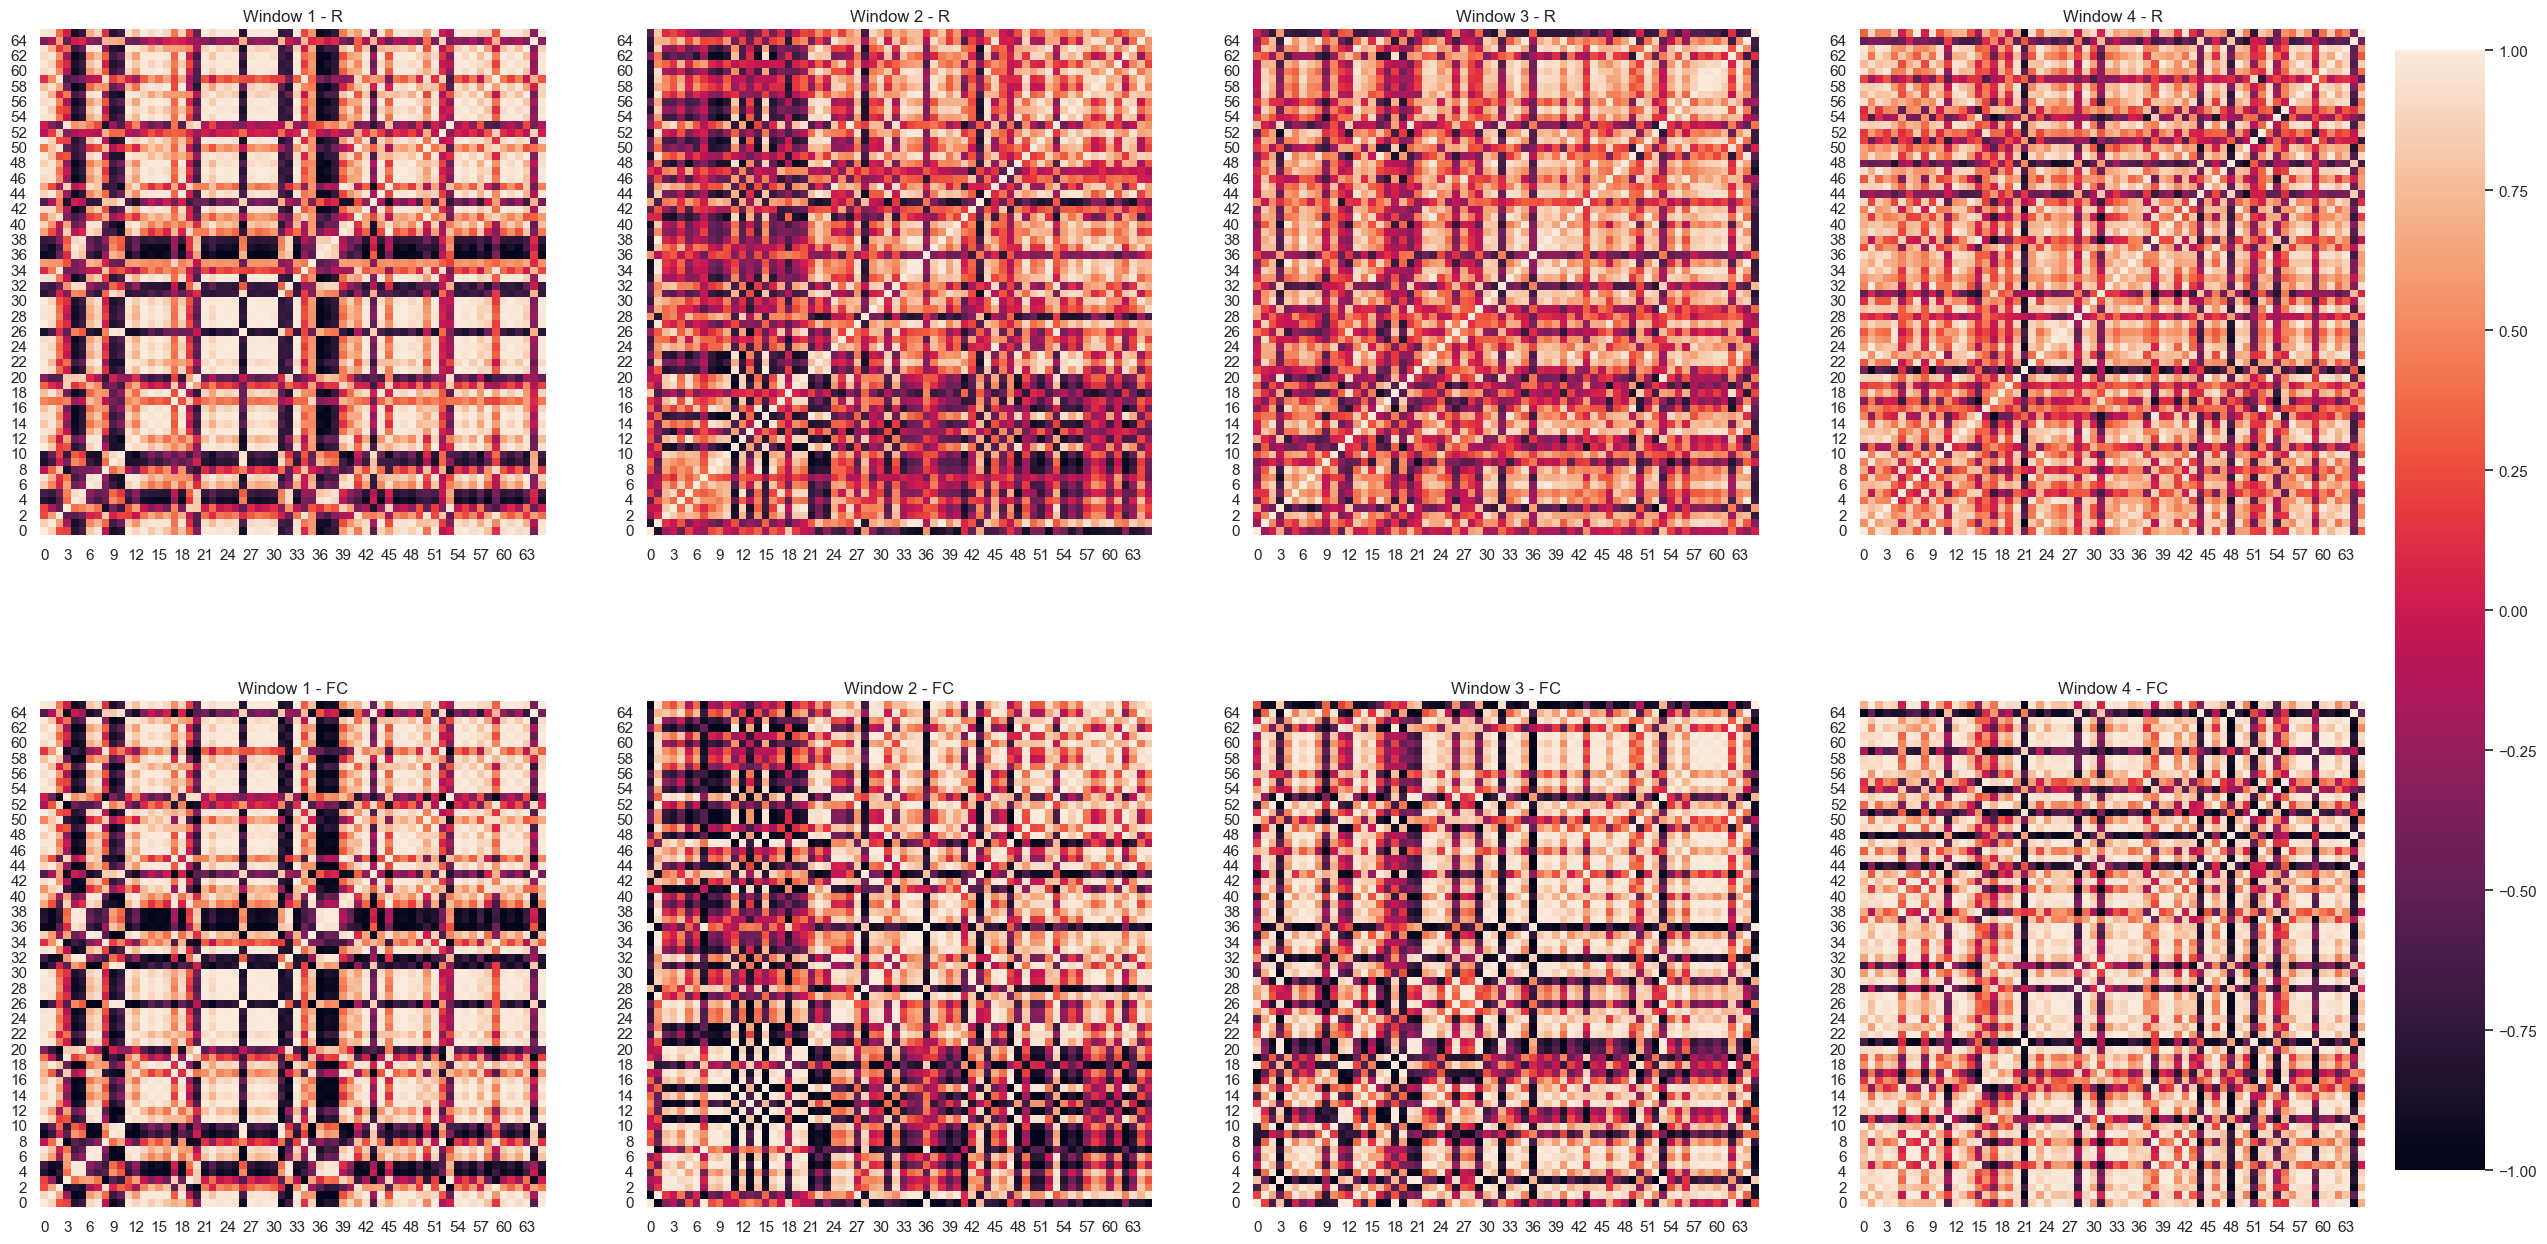

In [10]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,4)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(Average_Cos_Phase_Difference[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(Average_Cos_Phase_Difference[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(Average_Cos_Phase_Difference[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,3]= sns.heatmap(Average_Cos_Phase_Difference[:,:,3].T,ax=axs[0,3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,3].invert_yaxis()
axs[0,0].title.set_text('Window 1 - R')
axs[0,1].title.set_text('Window 2 - R')
axs[0,2].title.set_text('Window 3 - R')
axs[0,3].title.set_text('Window 4 - R')
axs[1,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,3]= sns.heatmap(SyntheticFC[:,:,3].T,ax=axs[1,3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,3].invert_yaxis()
axs[1,0].title.set_text('Window 1 - FC')
axs[1,1].title.set_text('Window 2 - FC')
axs[1,2].title.set_text('Window 3 - FC')
axs[1,3].title.set_text('Window 4 - FC')
fig.savefig('functionalpatterns.png')
plt.show()

### Now import structural connectivity and find a compatible frequency setting

In [11]:
SC_DF = pd.read_csv('StructuralConnectivity.csv',header=None)
SCMatrix = np.array(SC_DF)
#Remove Diagonals
SCMatrix = SCMatrix - np.diagflat(np.diag(SCMatrix))
SCMatrix = (SCMatrix+SCMatrix.T)/2

#Calculate quantities from inital parameters 
edges = KFB.CalculateEdgeSet(SCMatrix)
x_desired = np.zeros((len(edges),E))
D = np.zeros((len(edges),len(edges),E))
B = KFB.CalculateIncidenceMatrix(edges,N)
for w in range(0,E):
    x_desired[:,w] = KFB.CalculatePhaseDifferencesFromMin(x_min_brain[:,w],edges)
    D[:,:,w]= KFB.CalculateSinMatrix(edges,x_desired[:,w])
delta1 = KFB.CalculateDeltaFromAdj(SCMatrix,edges)

### There are three approaches to what we could now do:

1. We can aim to find a frequency setting (and maybe have changes to adjacency) that generate all three functional patterns with different initial conditions. This works but solving a convex optimisation problem with an additional constraint for each functional pattern. This would be optimal, but it doesn't seem to have a solution

2. We can aim to find the best fit to all three. This works by loosening the constraint be in the minimisation term. We aim to minimise the difference rather than have an equality constraint. This has a solution but the solution is terrible at reconstructing the functional patterns and therefore not really useful

These observations suggest that these 3 phase-locked patterns have different natural frequencies so cannot be fitted with a single frequency setting. We can calculate a different natural frequency for each functional pattern. 

3. Instead, if these functional patterns are generated by oscillators of different frequencies then we have to have a multi-frequency defnition of brain state.

In [129]:
# Construct the problem and solve the convex optimisation problem
delta_opt = cp.Variable((len(edges),1))
w_opt = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta_opt-delta1))
constraints = [delta_opt-delta1>=0]
for w in range(0,E):
    constraints.append(np.matmul(B,D[:,:,w])@delta_opt == w_opt)
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
SC_opt = KFB.CalculateAdjFromDelta(delta_opt.value,edges,N)
w_opt = w_opt.value

TypeError: 'NoneType' object is not subscriptable

In [12]:
# Construct the problem and solve the convex optimisation problem to find an optimal frequency setting for all three patterns
delta_opt = cp.Variable((len(edges),1))
w_opt = cp.Variable((N,1))
objective = cp.Minimize(cp.sum_squares(delta_opt-delta1)+ cp.sum_squares(np.matmul(B,D[:,:,0])@delta_opt - w_opt) + cp.sum_squares(np.matmul(B,D[:,:,1])@delta_opt - w_opt)+ cp.sum_squares(np.matmul(B,D[:,:,2])@delta_opt - w_opt))
constraints = [delta_opt-delta1>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
#Reobtain adjacency from delta vector and update frequencies
SC_opt = KFB.CalculateAdjFromDelta(delta_opt.value,edges,N)
w_opt = w_opt.value

In [14]:
#Solving the model with these params
T=40
num_points = 800
sol = np.zeros((num_points,N,E))
for w in range(0,E):
    theta_0 = EstimatedPhases[:,w]
    sol[:,:,w],t = KFB.SolveKuramotoModel(theta_0,T,N,w_opt+0.29,SC_opt,num_points,0)

In [15]:
rho = np.zeros((N,N,E))
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w]=np.mean(np.cos(sol[:,j,w]-sol[:,i,w]))
    rho[:,:,w] = rho[:,:,w] + rho[:,:,w].T + np.identity(N)

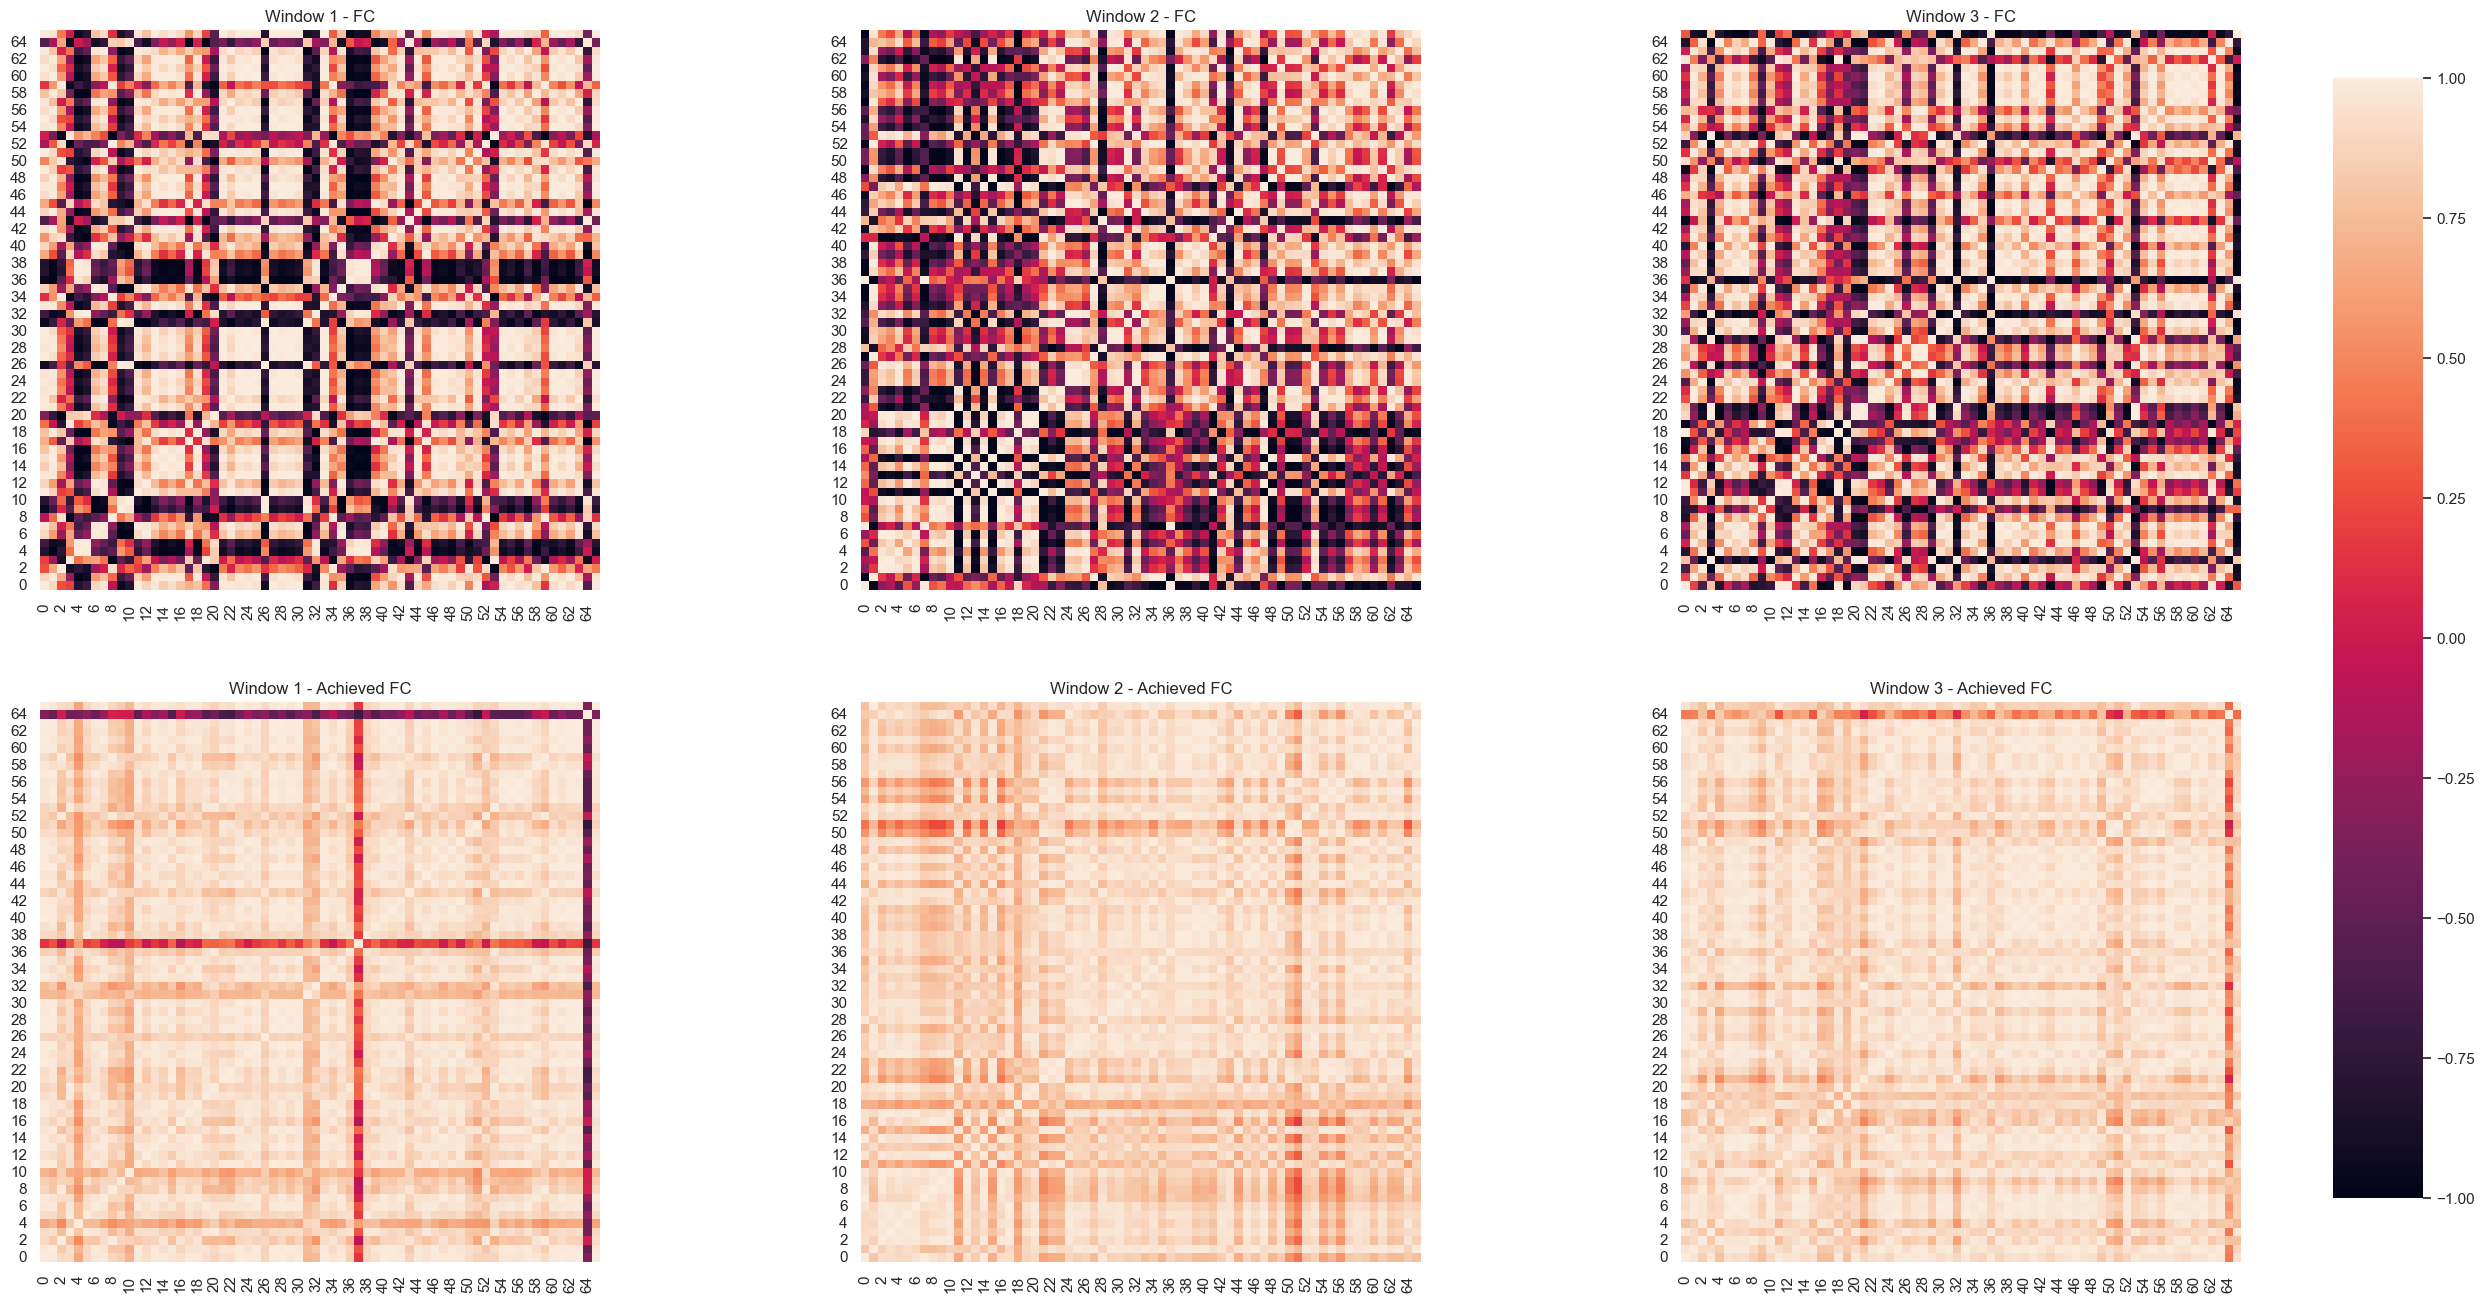

In [17]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,3)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,0].title.set_text('Window 1 - FC')
axs[0,1].title.set_text('Window 2 - FC')
axs[0,2].title.set_text('Window 3 - FC')
axs[1,0]= sns.heatmap(rho[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(rho[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(rho[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,0].title.set_text('Window 1 - Achieved FC')
axs[1,1].title.set_text('Window 2 - Achieved FC')
axs[1,2].title.set_text('Window 3 - Achieved FC')
fig.savefig('bestfitbadfit.png')
plt.show()


### Here we are trying to obtain three different frequency settings - one for each functional pattern

In [18]:
omega = np.zeros((N,1,E))
for w in range(0,E):
    omega[:,:,w]= np.matmul(B,D[:,:,w])@delta1

In [20]:
#Solving the model with these params
T=40
num_points = 800
sol = np.zeros((num_points,N,E))
for w in range(0,E):
    theta_0 = EstimatedPhases[:,w]
    sol[:,:,w],t = KFB.SolveKuramotoModel(theta_0,T,N,omega[:,:,w]+0.29,SCMatrix,num_points,0)

In [21]:
rho = np.zeros((N,N,E))
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w]=np.mean(np.cos(sol[:,j,w]-sol[:,i,w]))
    rho[:,:,w] = rho[:,:,w] + rho[:,:,w].T + np.identity(N)

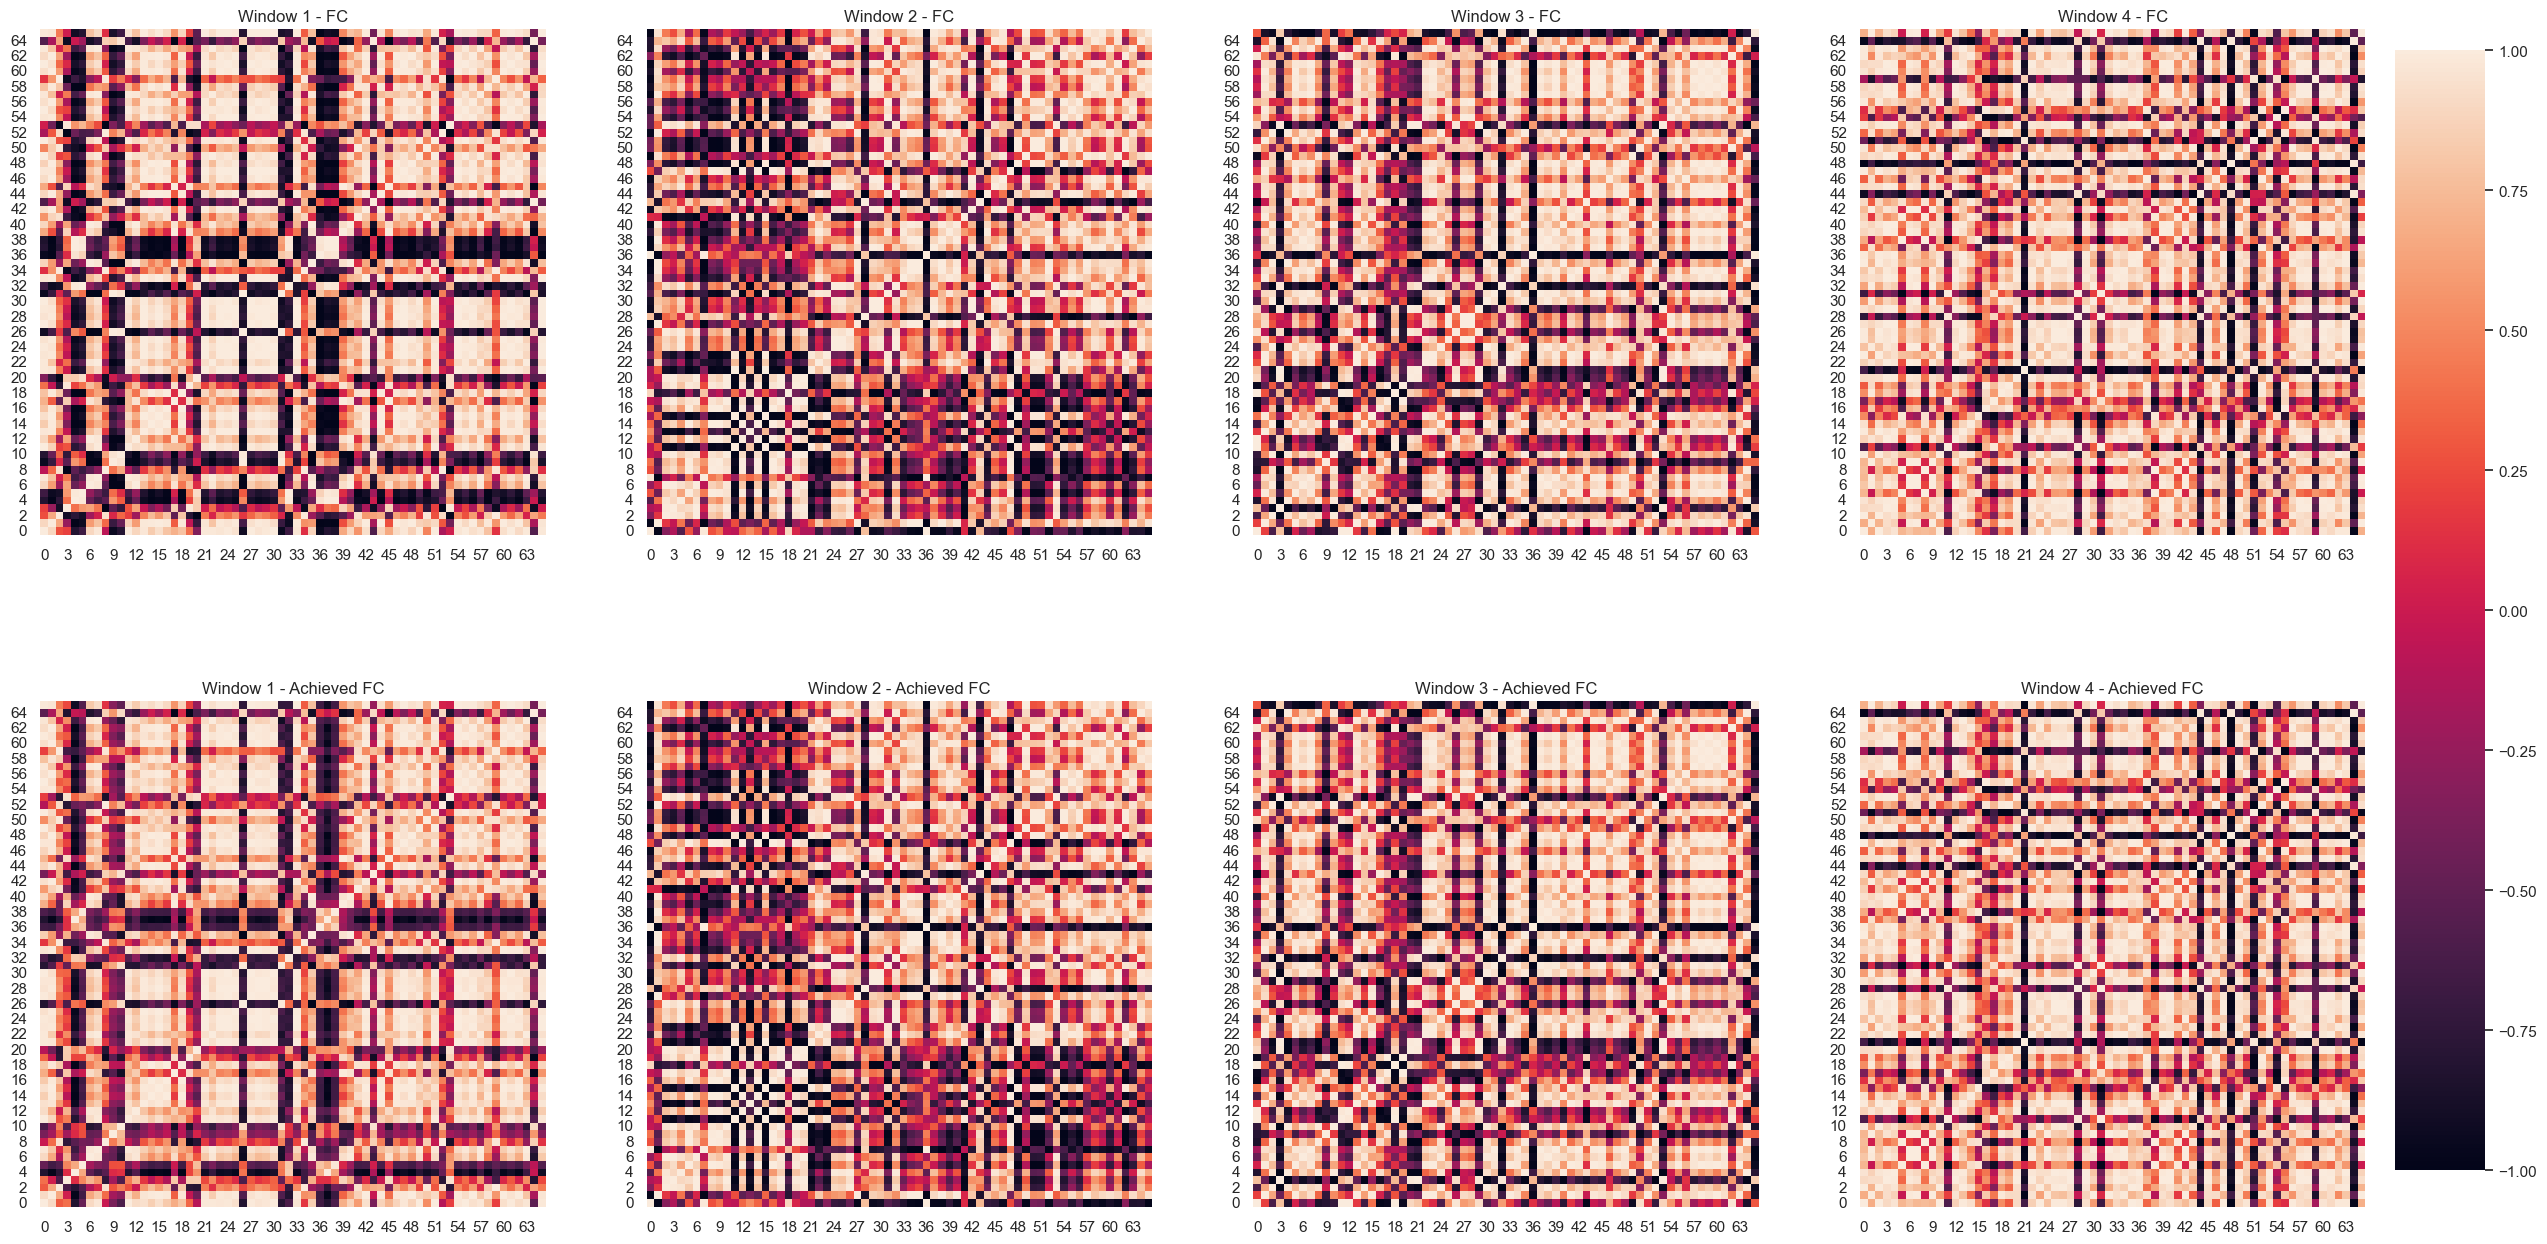

In [22]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(2,4)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0,0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[0,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,0].invert_yaxis()
axs[0,1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[0,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,1].invert_yaxis()
axs[0,2]= sns.heatmap(SyntheticFC[:,:,2].T,ax=axs[0,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,2].invert_yaxis()
axs[0,3]= sns.heatmap(SyntheticFC[:,:,3].T,ax=axs[0,3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0,3].invert_yaxis()
axs[0,0].title.set_text('Window 1 - FC')
axs[0,1].title.set_text('Window 2 - FC')
axs[0,2].title.set_text('Window 3 - FC')
axs[0,3].title.set_text('Window 4 - FC')
axs[1,0]= sns.heatmap(rho[:,:,0].T,ax=axs[1,0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,0].invert_yaxis()
axs[1,1]= sns.heatmap(rho[:,:,1].T,ax=axs[1,1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,1].invert_yaxis()
axs[1,2]= sns.heatmap(rho[:,:,2].T,ax=axs[1,2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,2].invert_yaxis()
axs[1,3]= sns.heatmap(rho[:,:,3].T,ax=axs[1,3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1,3].invert_yaxis()
axs[1,0].title.set_text('Window 1 - Achieved FC')
axs[1,1].title.set_text('Window 2 - Achieved FC')
axs[1,2].title.set_text('Window 3 - Achieved FC')
axs[1,3].title.set_text('Window 4 - Achieved FC')
fig.savefig('acheivedfunctionalpatterns.png')
plt.show()

### So we can recreate the 3 FP with 3 frequency settings. Assuming that the brain is switching between these phase-locked functional patterns, can we estimate how much time we spend in each one? Can we get a distribution on this?

This is not easy because using this approach of finding phase-locked states and defining each one as a functional pattern defeats the purpose of this definition, namely that these states are recurrent. Also, as you reduce the length of the time window, the number of local maxima (phase-locked states) does not stabilise but increases. This makes it impossible to find a meaningful optimal number of brain states. 

We can calculate a functional pattern at every given time step and then bin it according to which of the four above functional patterns it matches most closely to. If this approach is promising, we will know because some states will be recurrent and fairly continuous. Otherwise this is not a meaningful characterisation. 

In [23]:
BOLDPhases= Hilbert
BOLDPhases_no_mod= KFB.RemoveBounds(BOLDPhases)

#Complete identical steps to in previous cases to extract R and F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,300))
Phase_Differences = np.zeros((N,N,300))
for i in range(0,300):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(BOLDPhases_no_mod[i][k]-BOLDPhases_no_mod[i][j])
            Phase_Differences[j][k][i] = BOLDPhases_no_mod[i][k]-BOLDPhases_no_mod[i][j]

In [16]:
clustering = np.zeros((300,2))
d = np.zeros(E)
for t in range(0,300):
    for i in range(0,E):
        d[i]= np.linalg.norm(SyntheticFC[:,:,i]-Cos_Phase_Differences[:,:,t])
    c = np.argmin(d)
    clustering[t,0]=t
    clustering[t,1]=c
    

### Following the Awakenings method

Following the lead from the Awakenings method, instead of binning these matrices based on the phase-locked functional pattern that most closely resembles it, I can cluster these patterns and then find the centroid of the cluster and see how long is spent in each of these states. 

In [25]:
ConcatenatedCosPhaseDifferences = []
for t in range(0,300):
    ConcatenatedCosPhaseDifferences.append(np.concatenate(Cos_Phase_Differences[:,:,t]))
ConcatenatedCosPhaseDifferences = np.array(ConcatenatedCosPhaseDifferences)
kmeans = KMeans(n_clusters=5).fit(ConcatenatedCosPhaseDifferences)

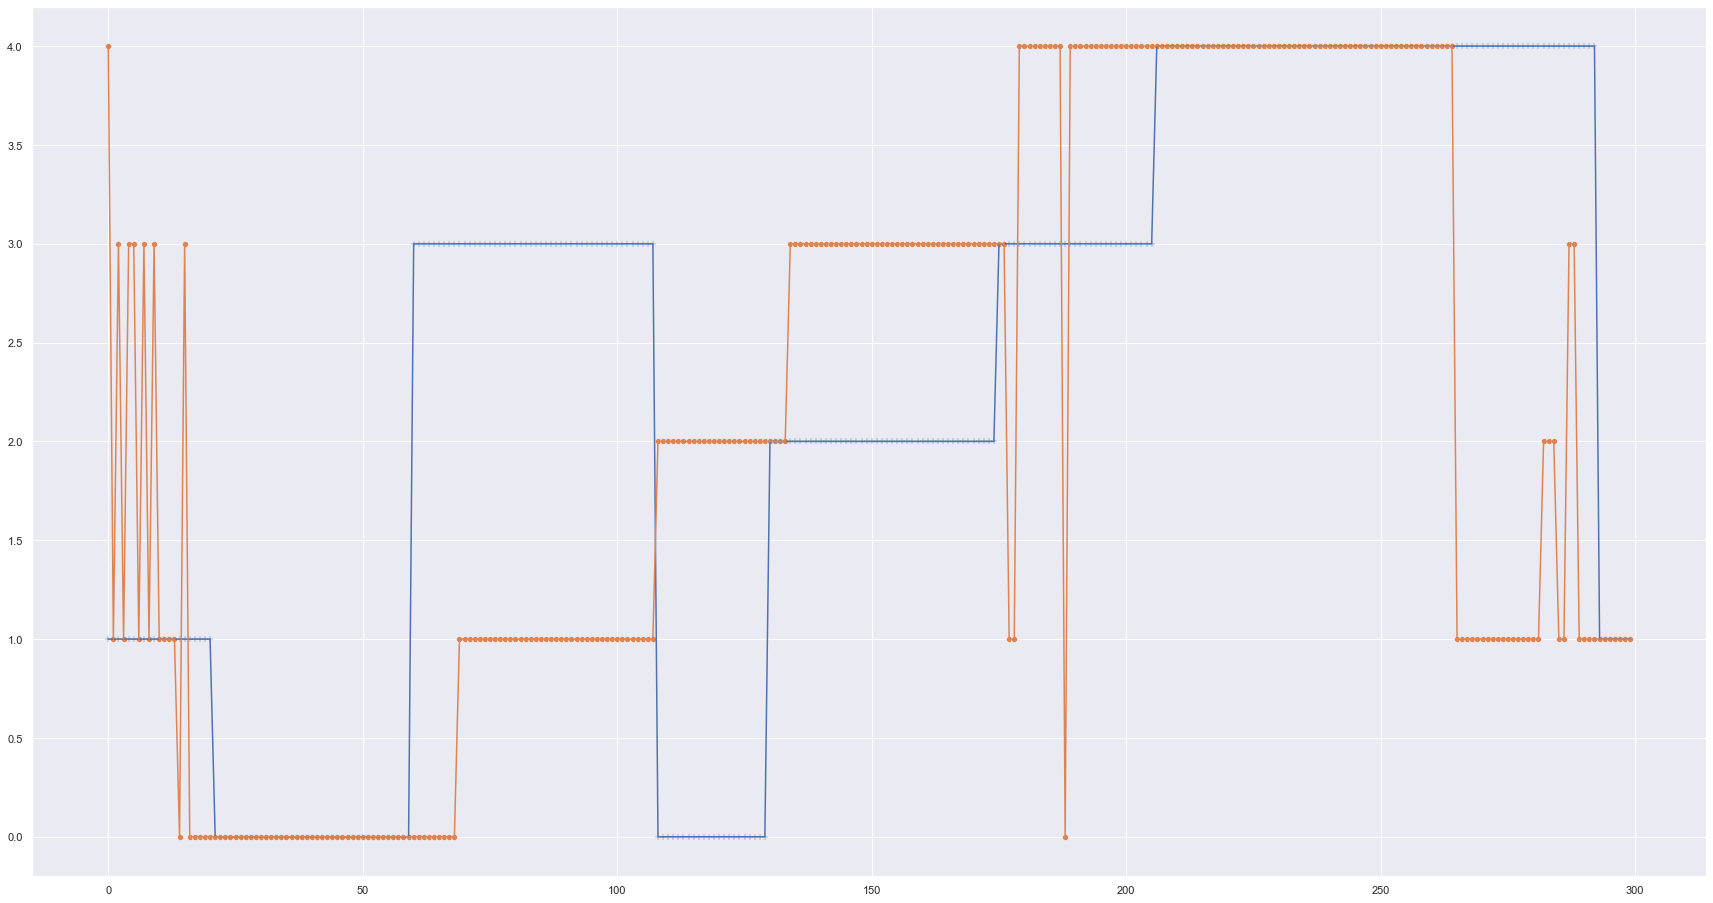

In [18]:
mapping = {3:4,2:0,1:3,0:2,4:1}
clusters = [mapping[i] for i in kmeans.labels_]
ax = sns.scatterplot(clusters,marker='+')
ax = sns.scatterplot(clustering[:,1],marker='o')
ax = sns.lineplot(clusters)
ax = sns.lineplot(clustering[:,1])

In [26]:
# Elbow analysis rather than silhouette

K = range(1,25)
Dist=[]
for k in K:
    kmeans = KMeans(n_clusters=k).fit(ConcatenatedCosPhaseDifferences)
    Dist.append(kmeans.inertia_)


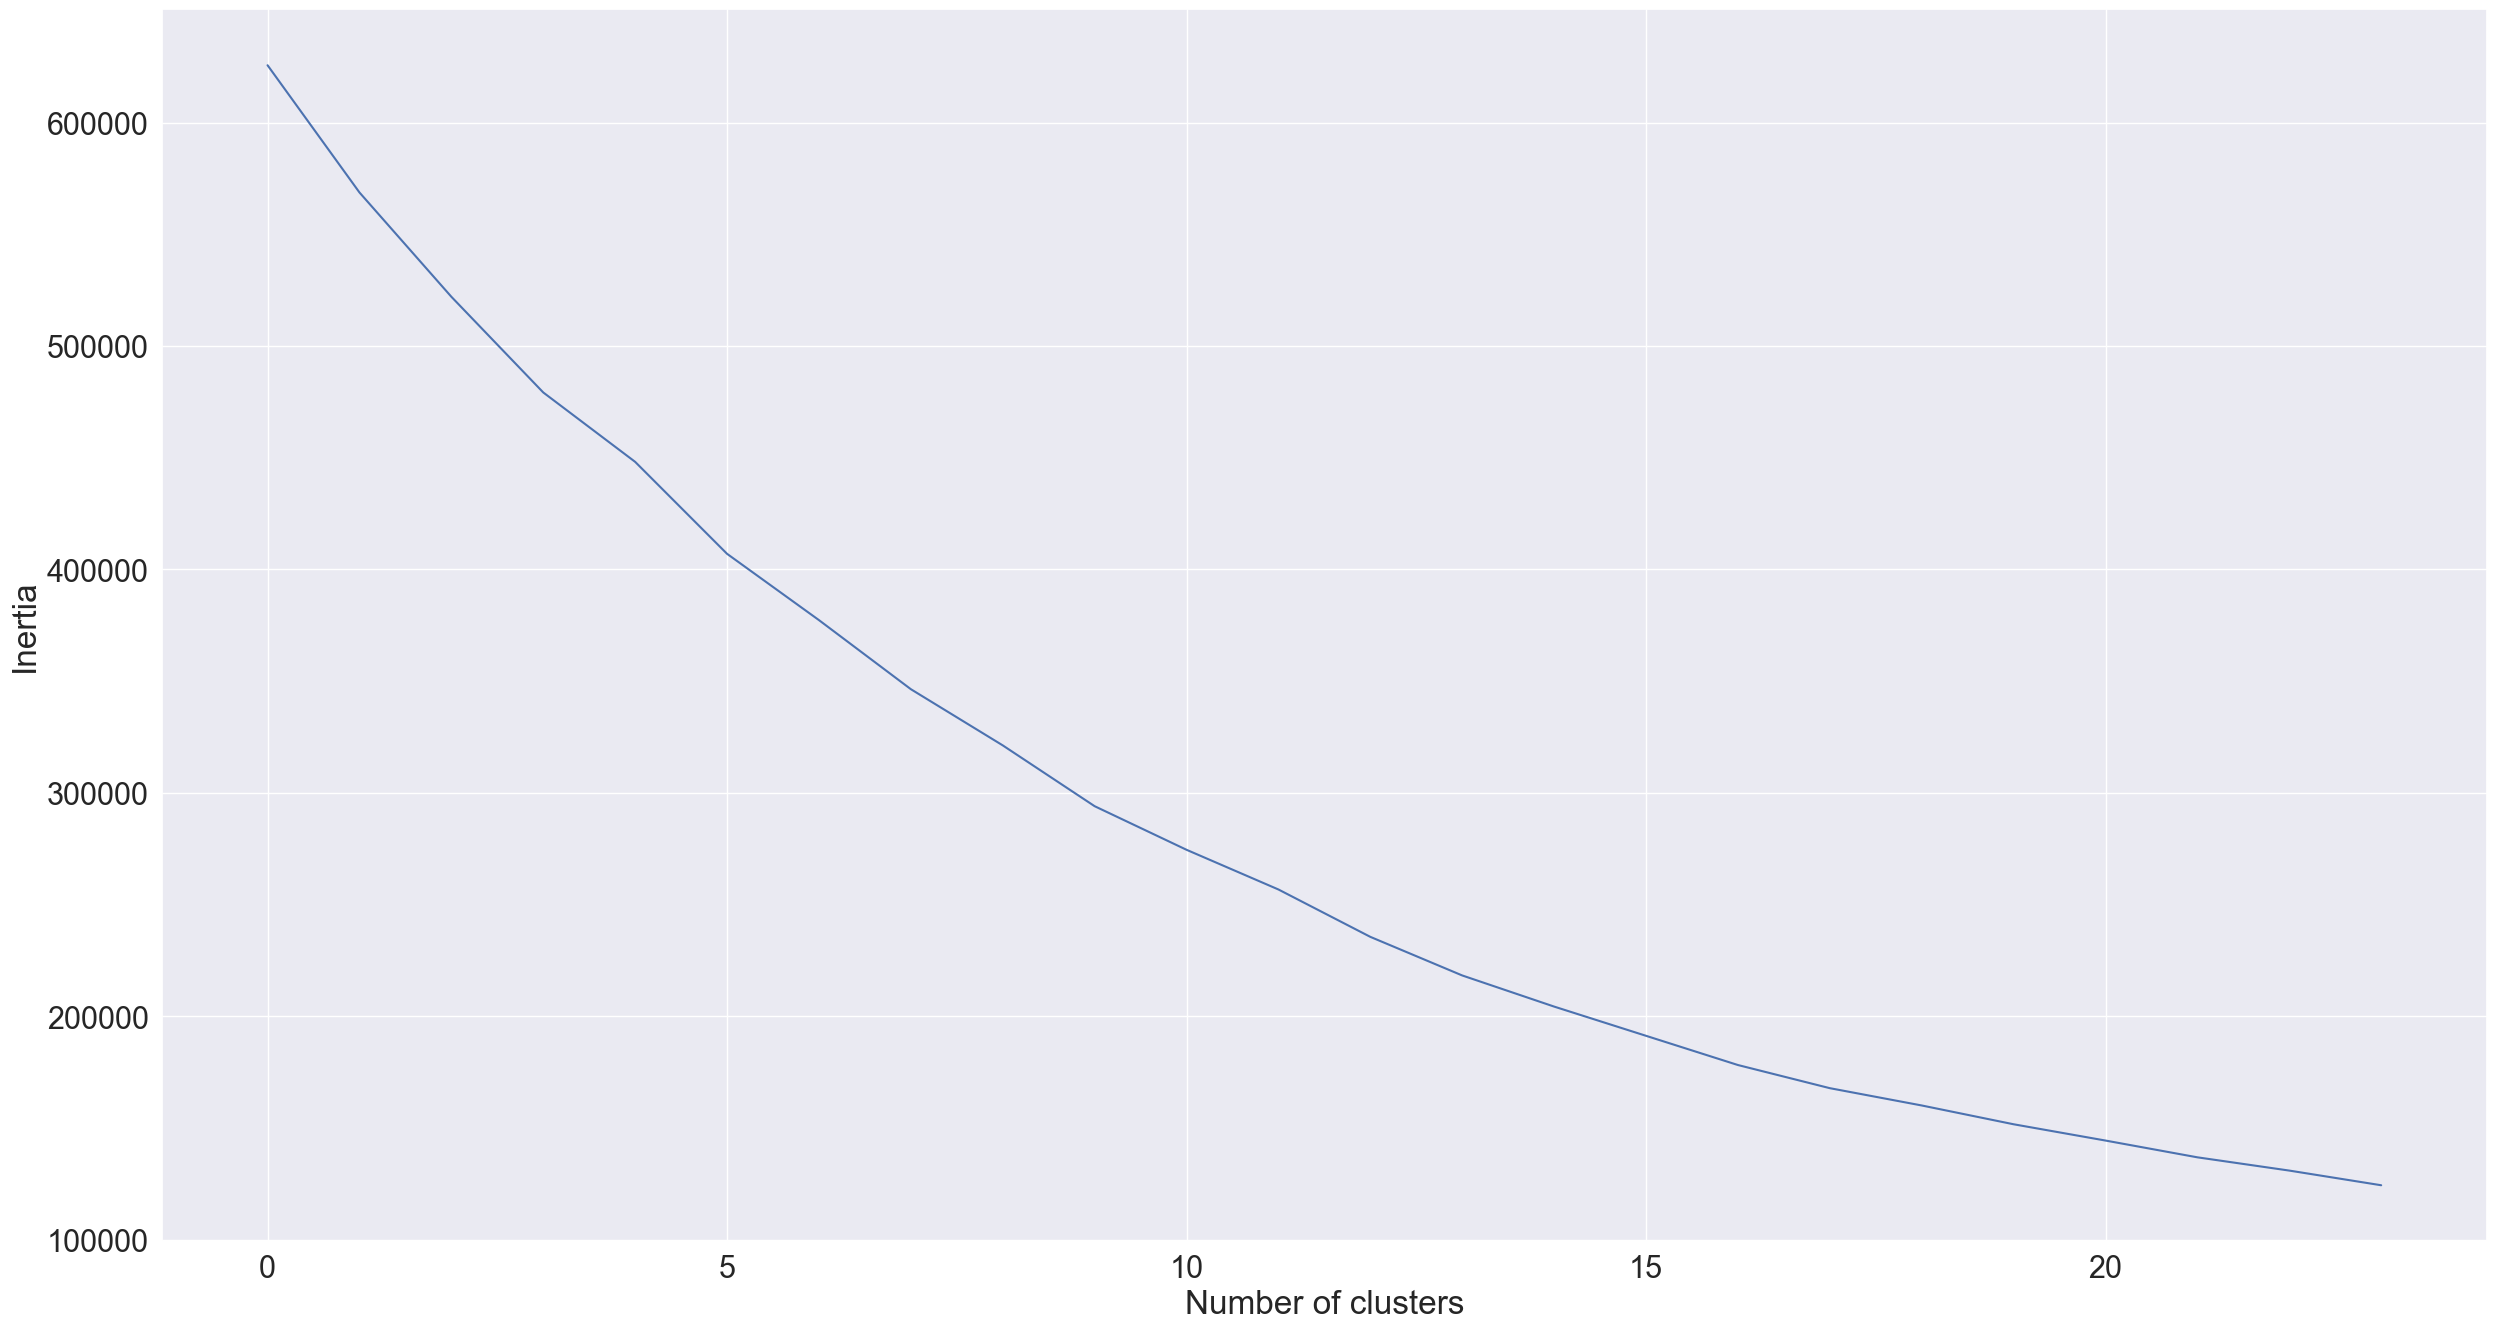

In [29]:
sns.set(font_scale=2)
fig = plt.figure()
ax = sns.lineplot(Dist)
ax.set(xlabel='Number of clusters', ylabel='Inertia')
fig.savefig('elbow.png', bbox_inches='tight')

## Smooth transitioning between functional patterns

In [35]:
T=40
num_points = 800
smooth_omega = np.zeros((N,1,T))
for t in range(0,int(T/2)):
    smooth_omega[:,:,t] = ((0.5*T-1-t)/(0.5*T-1))*omega[:,:,0]+ (t/(0.5*T-1))*omega[:,:,1]
for t in range(int(T/2),T):
    smooth_omega[:,:,t] = omega[:,:,1]
sol,t = KFB.SolveKuramotoModelTDFrequency(EstimatedPhases[:,0],T,N,smooth_omega[:,0,:]+0.29,SCMatrix,num_points,0)

In [ ]:
KFB.Sol

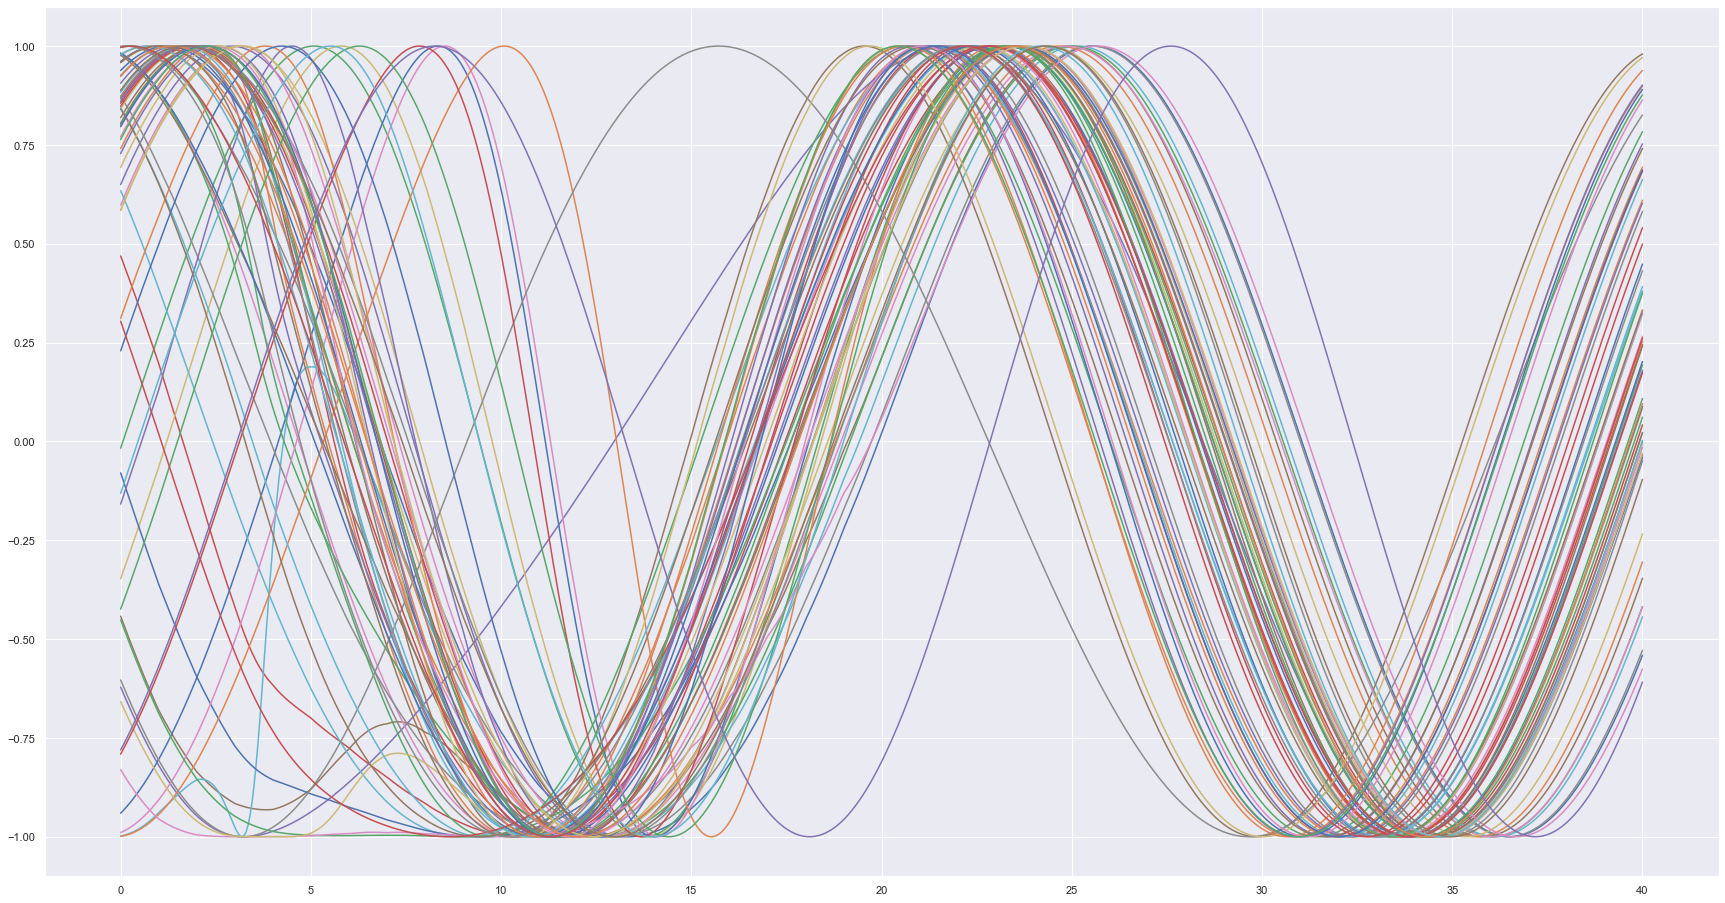

In [22]:
#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=np.sin(sol[:,i]))

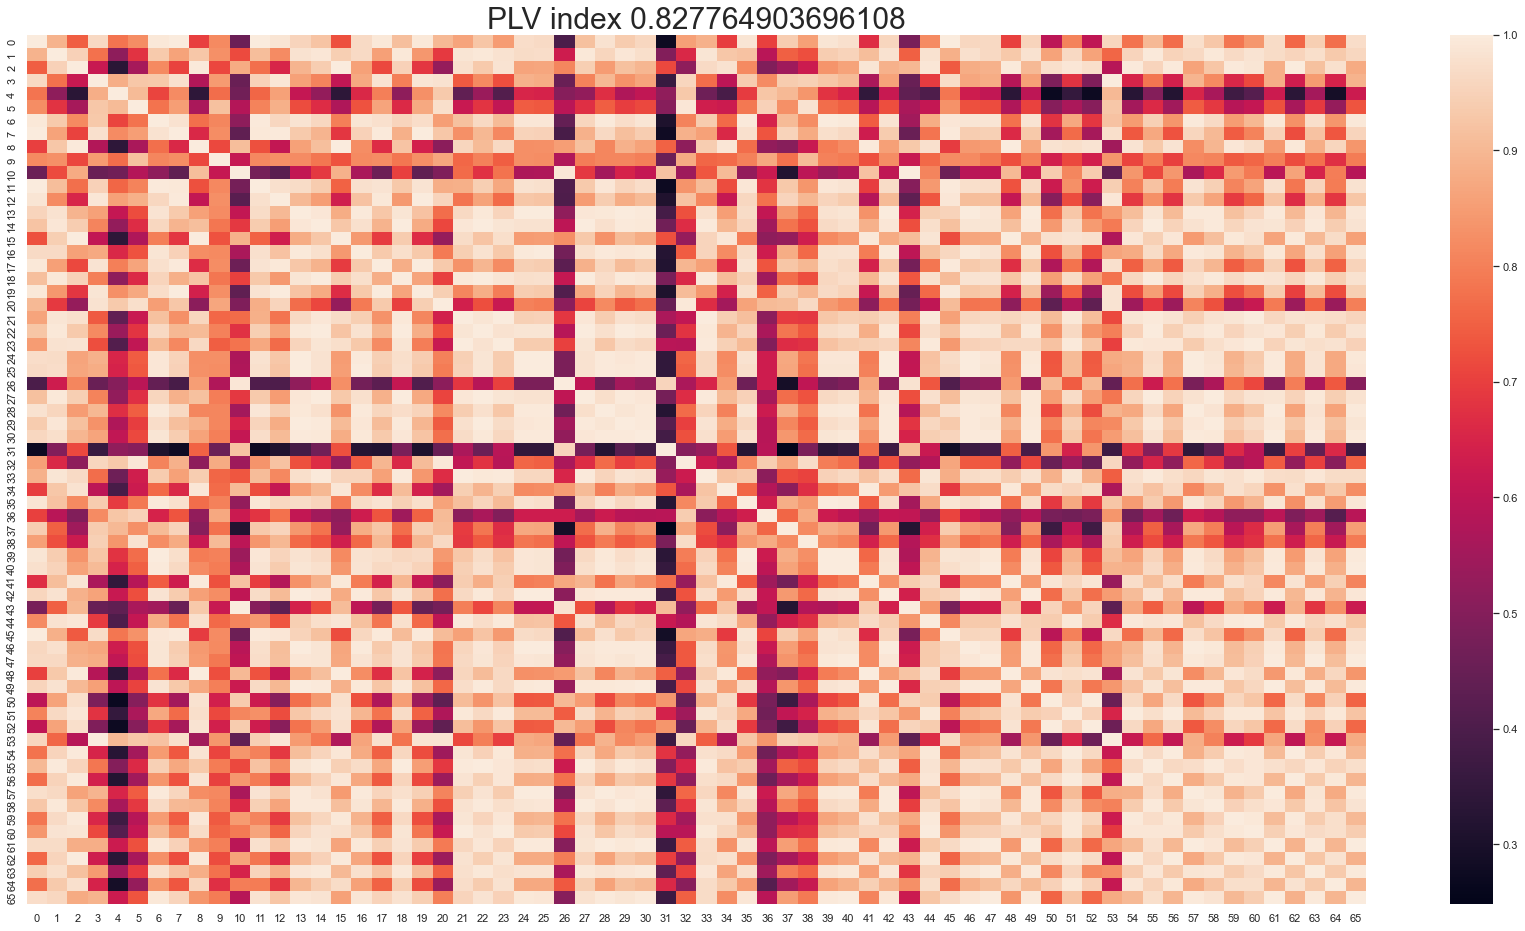

In [23]:
PLV = KFB.CalculatePhaseLockingValue(sol)
ax = sns.heatmap(PLV.T)
ax.invert_yaxis
PLV_index = KFB.CalculatePhaseLockingIndex(PLV)
ax.set_title('PLV index '+ str(PLV_index))
ax.title.set_size(30)

In [36]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

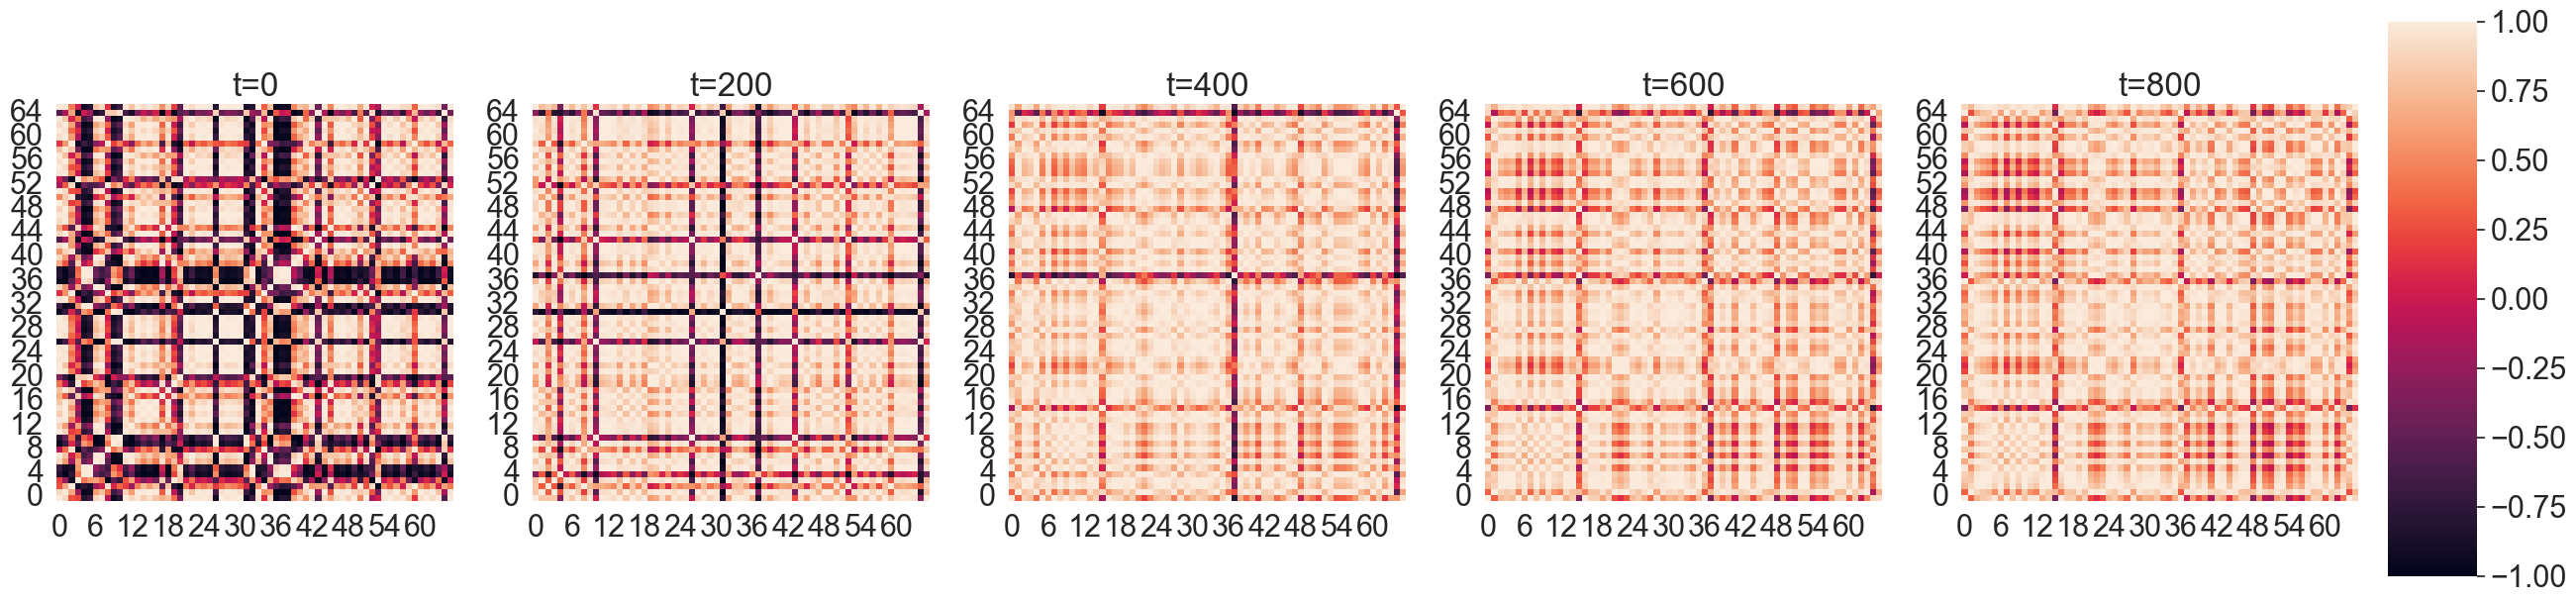

In [59]:
sns.set(rc={'figure.figsize':(30,8)},font_scale=2)
fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,199].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,399].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,599].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,799].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('t=0')
axs[1].title.set_text('t=200')
axs[2].title.set_text('t=400')
axs[3].title.set_text('t=600')
axs[4].title.set_text('t=800')
fig.savefig('unstabletransitions.png', bbox_inches='tight')

Transitioning between functional patterns is not as simple as it initally seems in the Kuramoto system as the functional patterns are not necessarily attractive from the initial conditions of another FP. This means that in order for a transition to occur some pertubation has to be made to the actual phase of the oscillator or something has to be done to improve the numerical stability of the system. This is not explore in the Bassett paper, because when considering moving between states, they simply change the parameters and run the simulation again from whatever desired initial condition they have. They do not smoothly move the w or A parameters as part of the dynamics.

### Promoting stability heuristically with modifications to the structural network

Bassett et al present a method for heuristically improving the stability a functional pattern by moving the eigenvectors into the left half-plane. This is done with modifications to the adjacency matrix through another convex optimisation problem. Hopefully this will make FP2 more stable and cause the above method to transition between the FPs.

In [46]:
negative_indices =[]
for i in range(0,delta1.shape[0]):
    if delta1[i,0]*np.cos(x_desired[i,0])<0:
        negative_indices.append(i)
delta_N = delta1[negative_indices]

In [47]:
# Construct the problem and solve the convex optimisation problem to find an optimal frequency setting for all three patterns
alpha = cp.Variable((len(edges),1))
objective = cp.Minimize(cp.sum_squares(delta_N+alpha[negative_indices]))
constraints = [np.matmul(B,D[:,:,0])@(delta1+alpha)==omega[:,:,0],delta1 + alpha>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
mod_delta = delta1 + alpha.value
newSC = KFB.CalculateAdjFromDelta(mod_delta,edges,N)

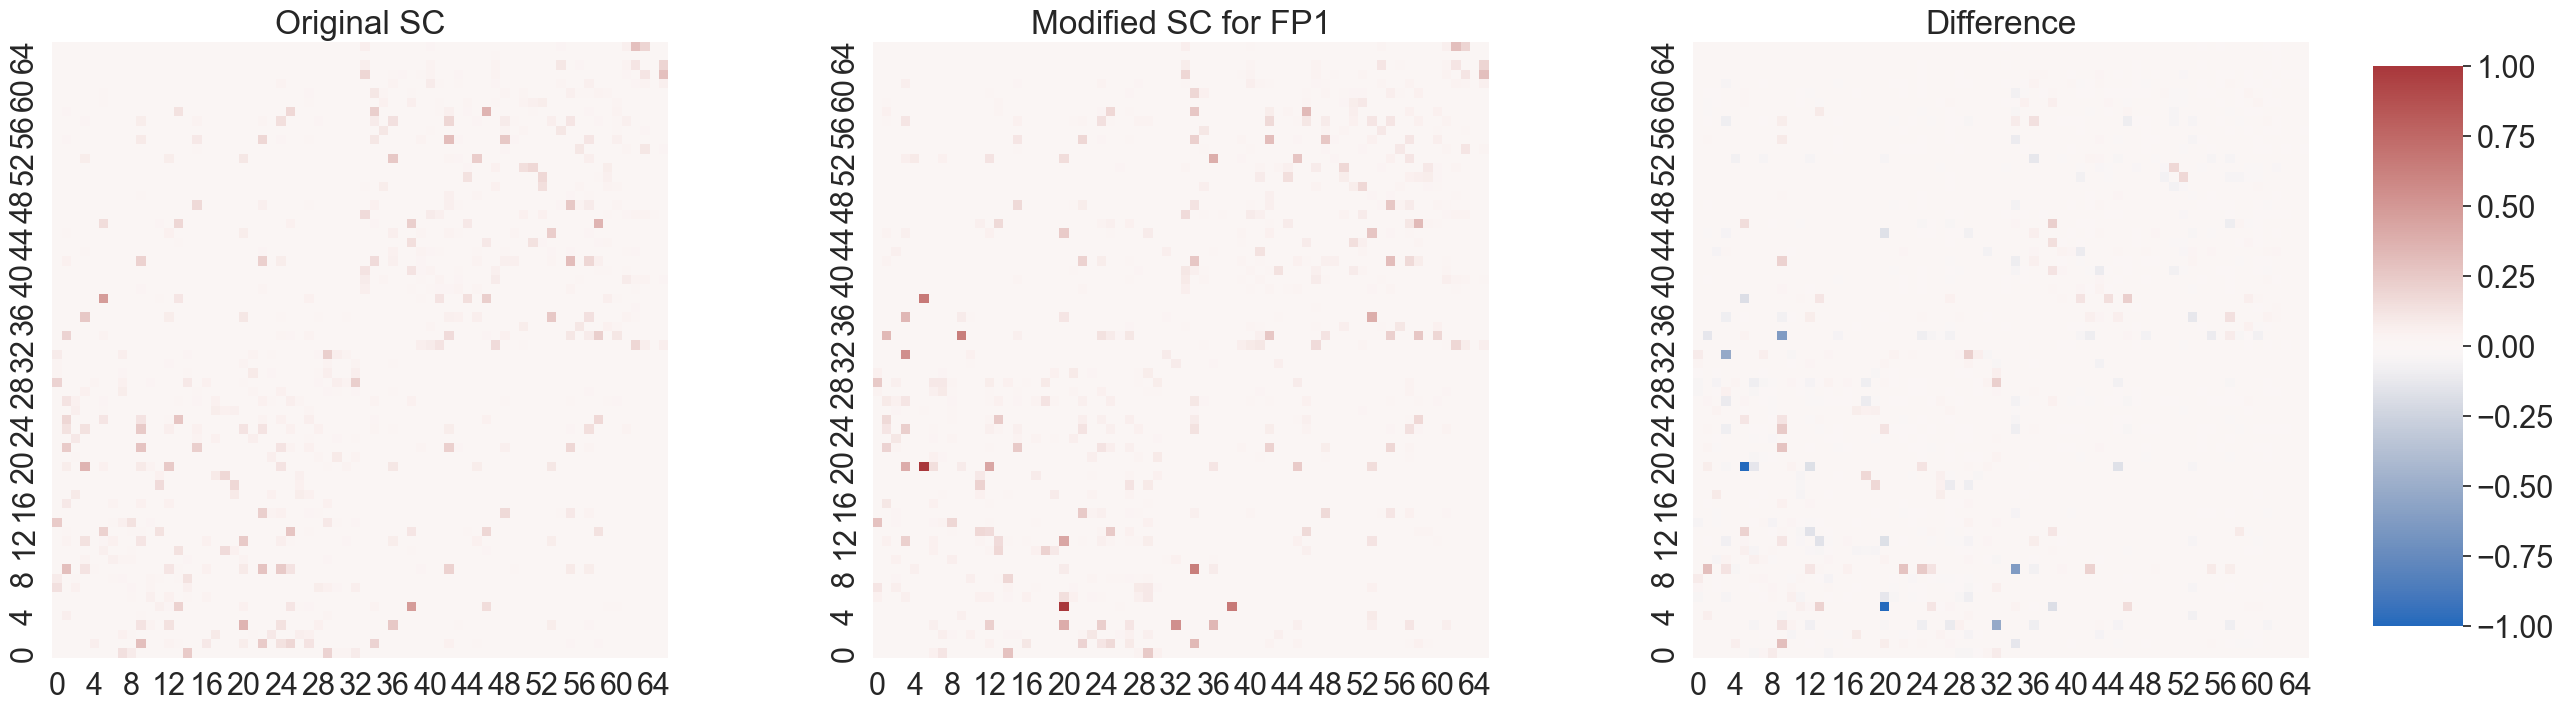

In [60]:
sns.set(rc={'figure.figsize':(30,8)},font_scale=2)
fig, axs = plt.subplots(1,3)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(SCMatrix.T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax,cmap="vlag")
axs[0].invert_yaxis()
axs[1]= sns.heatmap(newSC.T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax,cmap="vlag")
axs[1].invert_yaxis()
axs[2]= sns.heatmap(SCMatrix.T-newSC.T,ax=axs[2],square=True,vmin=-1,vmax=1,cmap="vlag",cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[0].title.set_text('Original SC')
axs[1].title.set_text('Modified SC for FP1')
axs[2].title.set_text('Difference')
fig.savefig('modifiedsc.png', bbox_inches='tight')

In [29]:
sol = np.zeros((num_points,N,5))
for i in range(0,5):
    sol[:,:,i],t = KFB.SolveKuramotoModel(EstimatedPhases[:,i],T,N,omega[:,0,0]+0.29,newSC,num_points)

In [30]:
sol2 = np.zeros((num_points,N,5))
for i in range(0,5):
    sol2[:,:,i],t = KFB.SolveKuramotoModel(EstimatedPhases[:,i],T,N,omega[:,0,0]+0.29,SCMatrix,num_points)

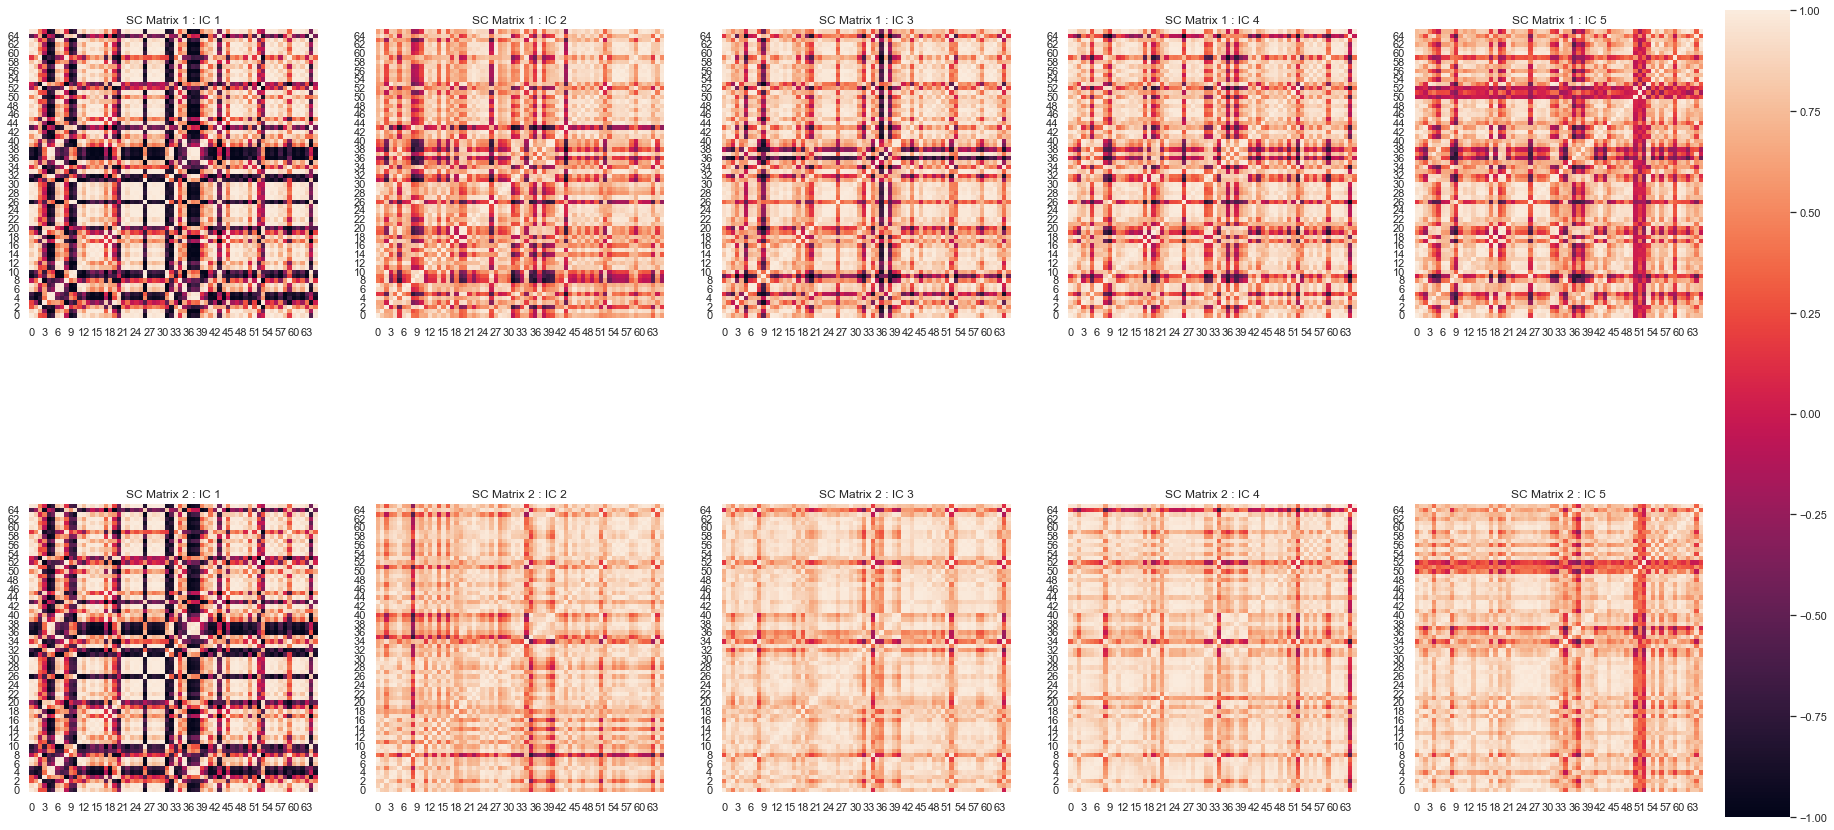

In [31]:
rho = np.zeros((N,N,E,2))
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w,0]=np.mean(np.cos(sol[:,j,w]-sol[:,i,w]))
    rho[:,:,w,0] = rho[:,:,w,0] + rho[:,:,w,0].T + np.identity(N)
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w,1]=np.mean(np.cos(sol2[:,j,w]-sol2[:,i,w]))
    rho[:,:,w,1] = rho[:,:,w,1] + rho[:,:,w,1].T + np.identity(N)


fig, axs = plt.subplots(2,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
for j in range(0,2):
    for i in range(0,E):
        axs[j,i]= sns.heatmap(rho[:,:,i,j].T,ax=axs[j,i],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
        axs[j,i].invert_yaxis()
        axs[j,i].title.set_text('SC Matrix ' + str(j+1) +' : IC '+ str(i+1))


So this heuristic approach has improved stability slightly but not by enough to force transitions between functional patterns i.e. the frames in the top row look more like the left than those in the bottom row

In [32]:

T=80
num_points=1600
sol = np.zeros((num_points,N,5))
sol2 = np.zeros((num_points,N,5))


for i in range(0,5):
    noise = np.random.normal(0,1,N)
    sol[:,:,i],t = KFB.SolveKuramotoModel(EstimatedPhases[:,0]+noise ,T,N,omega[:,0,0]+0.29,newSC,num_points)
    sol2[:,:,i],t = KFB.SolveKuramotoModel(EstimatedPhases[:,0]+noise,T,N,omega[:,0,0]+0.29,SCMatrix,num_points)


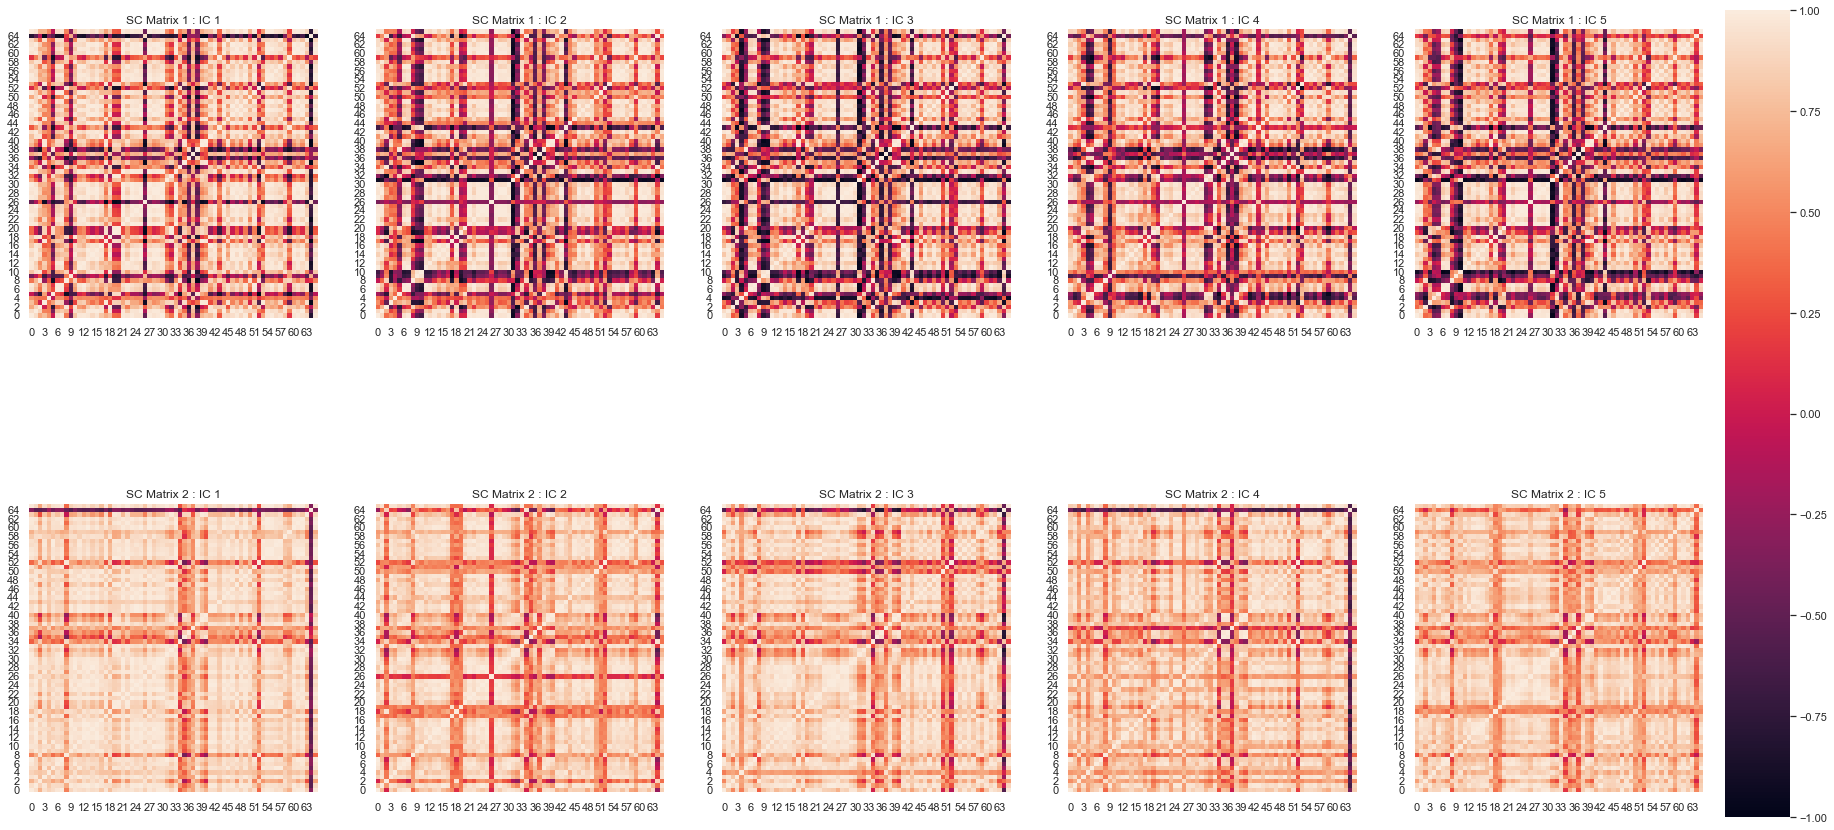

In [33]:
rho = np.zeros((N,N,E,2))
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w,0]=np.mean(np.cos(sol[:,j,w]-sol[:,i,w]))
    rho[:,:,w,0] = rho[:,:,w,0] + rho[:,:,w,0].T + np.identity(N)
for w in range(0,E):
    for i in range(0,N):
        for j in range(i+1,N):
            rho[i,j,w,1]=np.mean(np.cos(sol2[:,j,w]-sol2[:,i,w]))
    rho[:,:,w,1] = rho[:,:,w,1] + rho[:,:,w,1].T + np.identity(N)


fig, axs = plt.subplots(2,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
for j in range(0,2):
    for i in range(0,E):
        axs[j,i]= sns.heatmap(rho[:,:,i,j].T,ax=axs[j,i],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
        axs[j,i].invert_yaxis()
        axs[j,i].title.set_text('SC Matrix ' + str(j+1) +' : IC '+ str(i+1))


### Varying the adjacency and the frequency

In [61]:
negative_indices =[]
for i in range(0,delta1.shape[0]):
    if delta1[i,0]*np.cos(x_desired[i,1])<0:
        negative_indices.append(i)
delta_N = delta1[negative_indices]
# Construct the problem and solve the convex optimisation problem to find an optimal frequency setting for all three patterns
alpha = cp.Variable((len(edges),1))
objective = cp.Minimize(cp.sum_squares(delta_N+alpha[negative_indices]))
constraints = [np.matmul(B,D[:,:,1])@(delta1+alpha)==omega[:,:,1],delta1 + alpha>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
mod_delta = delta1 + alpha.value
newSC = KFB.CalculateAdjFromDelta(mod_delta,edges,N)

In [64]:
T=160
num_points = 3200
smooth_omega = np.zeros((N,1,T))
smooth_A = np.zeros((N,N,T))
for t in range(0,int(T/8)):
    smooth_omega[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*omega[:,:,0]+ (t/(0.125*T-1))*omega[:,:,1]
    smooth_A[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*SCMatrix+ (t/(0.125*T-1))*newSC
for t in range(int(T/8),T):
    smooth_omega[:,:,t] = omega[:,:,1]
    smooth_A[:,:,t]=newSC
sol,t = KFB.SolveKuramotoModelTDFrequencyAdj(EstimatedPhases[:,0],T,N,smooth_omega[:,0,:]+0.29,smooth_A,num_points,0)

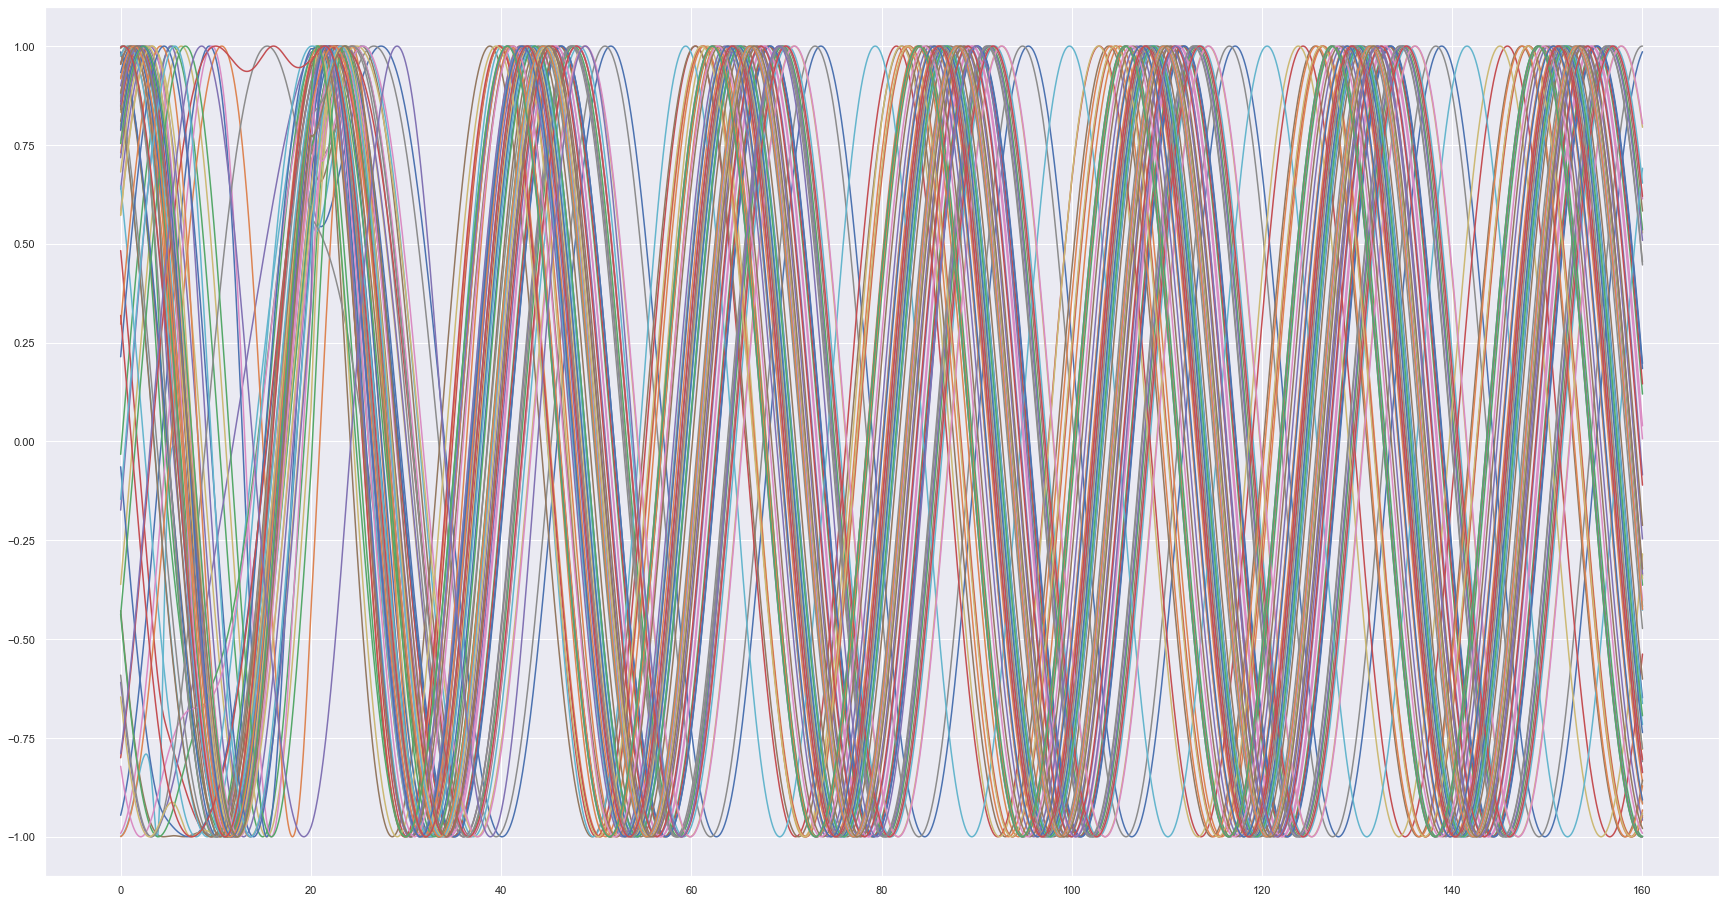

In [111]:
#Plot oscillator trajcetories
for i in range(0,N):
    ax = sns.lineplot(x=t,y=np.sin(sol[:,i]))

In [65]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

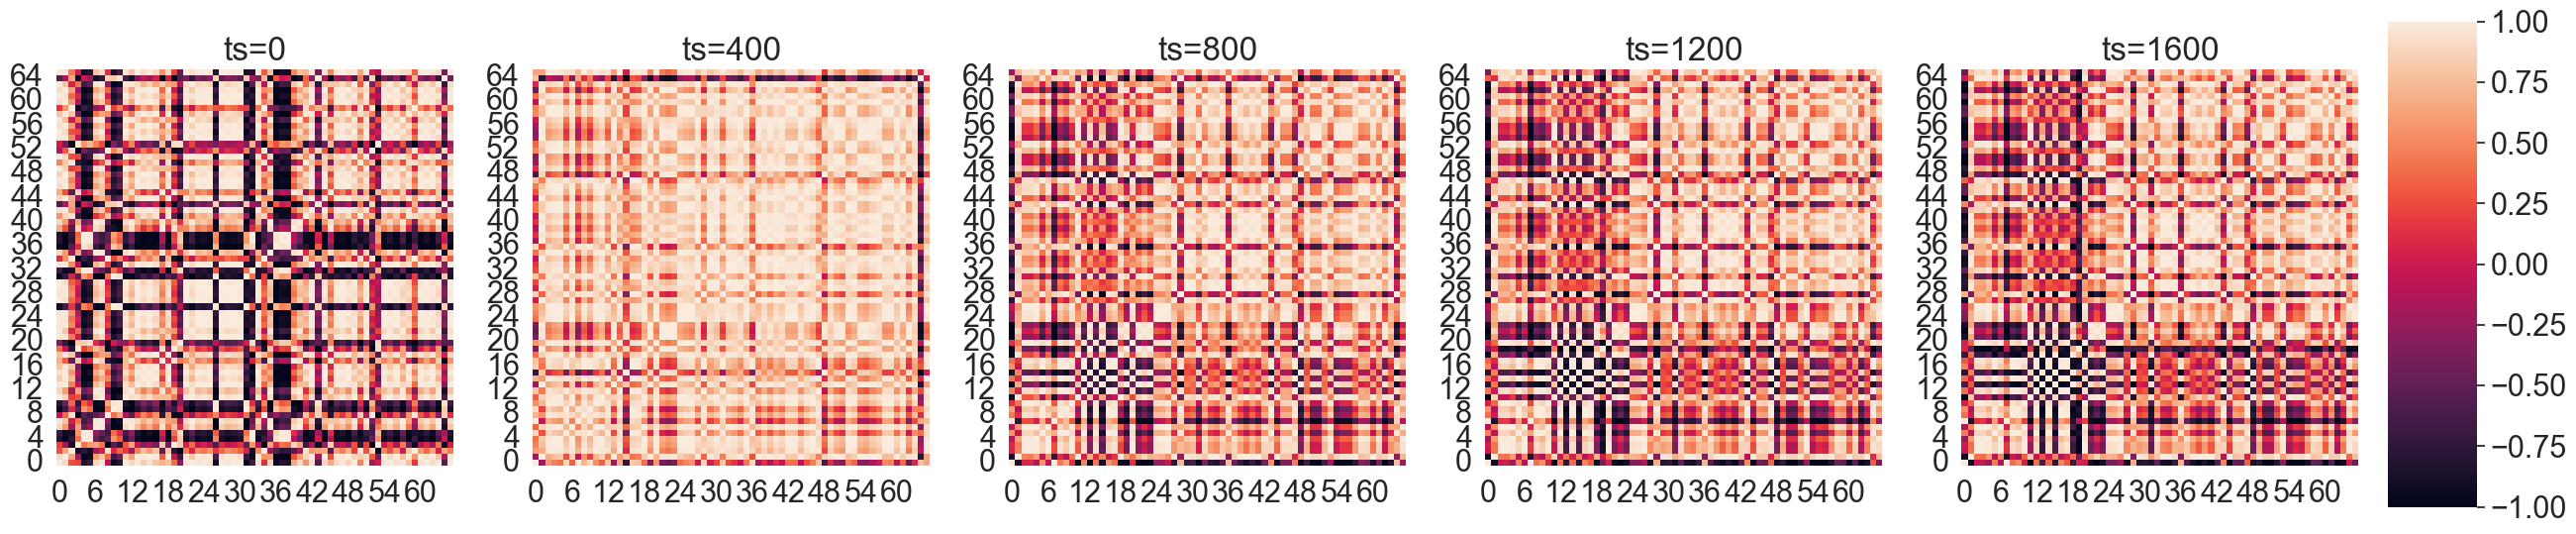

In [70]:
sns.set(rc={'figure.figsize':(30,7)},font_scale=2)

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,399].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,799].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,1199].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=400')
axs[2].title.set_text('ts=800')
axs[3].title.set_text('ts=1200')
axs[4].title.set_text('ts=1600')
fig.savefig('transitions12.png', bbox_inches='tight')

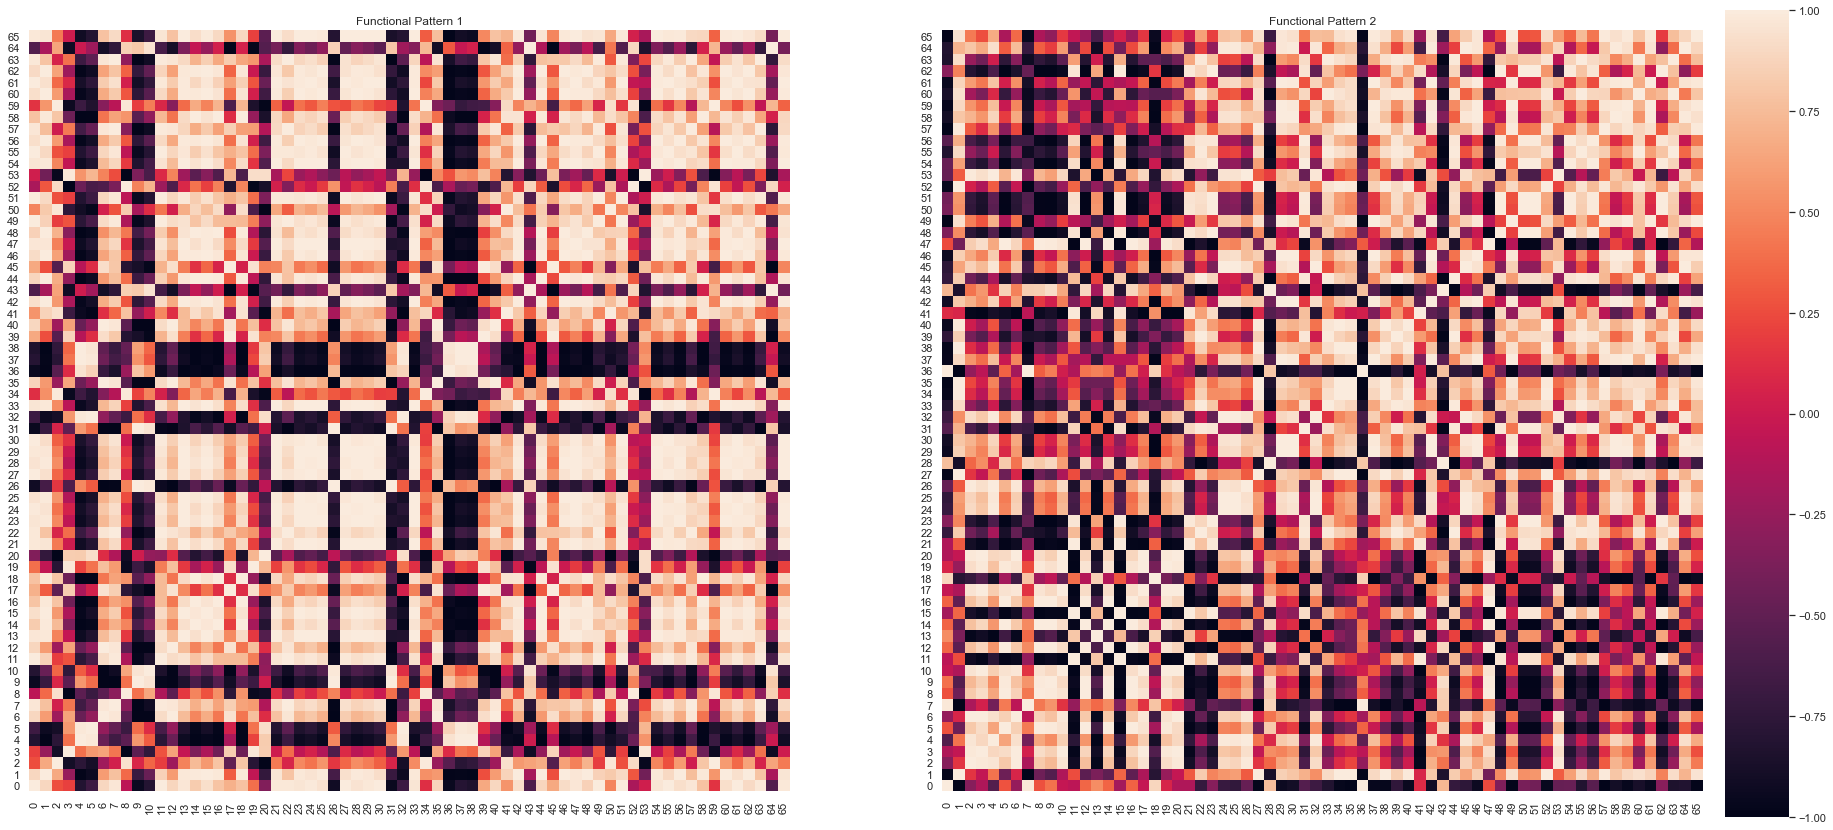

In [114]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,2)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(SyntheticFC[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(SyntheticFC[:,:,1].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[0].title.set_text('Functional Pattern 1')
axs[1].title.set_text('Functional Pattern 2')


If we vary the structural connectivity matrix to the one that increases the stability of FP2, we get a result! The basin of attraction of functional pattern 2 is now large enough that we can make our way from functional pattern 1 into functional pattern 2.

Can we make transitions between FP2 and FP1 - this is an interesting problem as it does not occur in the data

In [32]:
negative_indices =[]
for i in range(0,delta1.shape[0]):
    if delta1[i,0]*np.cos(x_desired[i,0])<0:
        negative_indices.append(i)
delta_N = delta1[negative_indices]
# Construct the problem and solve the convex optimisation problem to find an optimal frequency setting for all three patterns
alpha = cp.Variable((len(edges),1))
objective = cp.Minimize(cp.sum_squares(delta_N+alpha[negative_indices]))
constraints = [np.matmul(B,D[:,:,0])@(delta1+alpha)==omega[:,:,0],delta1 + alpha>=0]
prob = cp.Problem(objective, constraints)
result = prob.solve()
mod_delta = delta1 + alpha.value
newSC = KFB.CalculateAdjFromDelta(mod_delta,edges,N)

In [33]:
T=160
num_points = 3200
smooth_omega = np.zeros((N,1,T))
smooth_A = np.zeros((N,N,T))
for t in range(0,int(T/8)):
    smooth_omega[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*omega[:,:,1]+ (t/(0.125*T-1))*omega[:,:,0]
    smooth_A[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*SCMatrix+ (t/(0.125*T-1))*newSC
for t in range(int(T/8),T):
    smooth_omega[:,:,t] = omega[:,:,0]
    smooth_A[:,:,t]=newSC
sol,t = KFB.SolveKuramotoModeTDFrequencyAdj(EstimatedPhases[:,1],T,N,smooth_omega[:,0,:]+0.29,smooth_A,num_points)

In [34]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

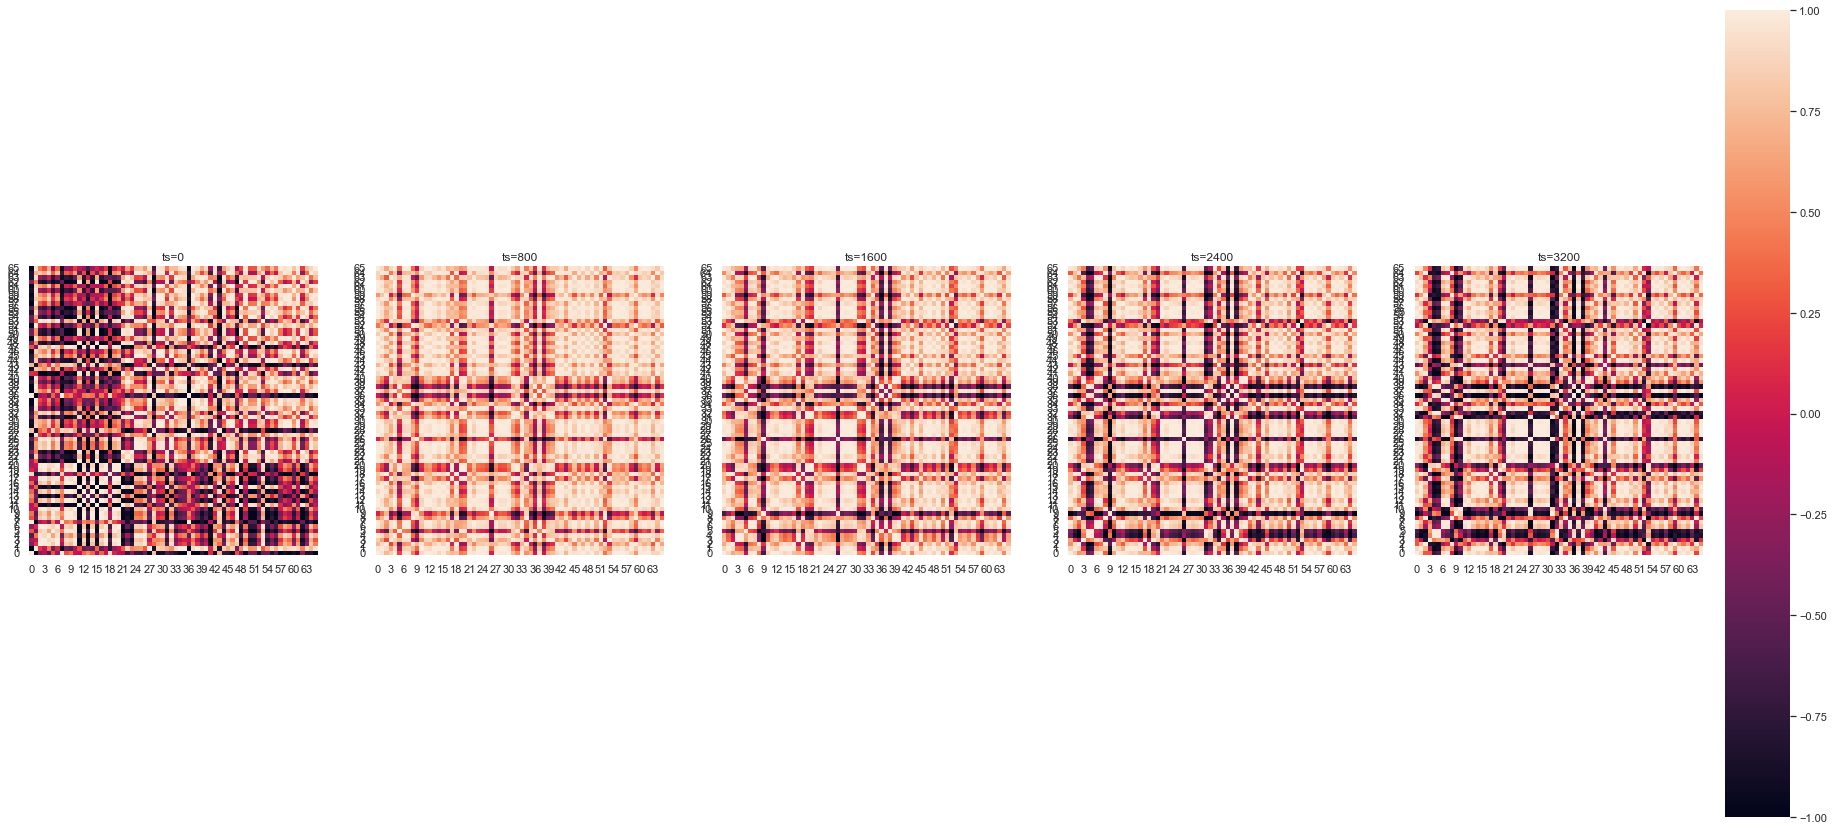

In [35]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,799].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,2399].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,3199].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=800')
axs[2].title.set_text('ts=1600')
axs[3].title.set_text('ts=2400')
axs[4].title.set_text('ts=3200')

## Attempting to flow between 4 functional patterns in sequence

In [9]:
StableSC = np.zeros((N,N,4))
for j in range(1,5):
    negative_indices =[]
    for i in range(0,delta1.shape[0]):
        if delta1[i,0]*np.cos(x_desired[i,j])<0:
            negative_indices.append(i)
    delta_N = delta1[negative_indices]
# Construct the problem and solve the convex optimisation problem to find an optimal frequency setting for all three patterns
    alpha = cp.Variable((len(edges),1))
    objective = cp.Minimize(cp.sum_squares(delta_N+alpha[negative_indices]))
    constraints = [np.matmul(B,D[:,:,j])@(delta1+alpha)==omega[:,:,j],delta1 + alpha>=0]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    mod_delta = delta1 + alpha.value
    StableSC[:,:,j-1] = KFB.CalculateAdjFromDelta(mod_delta,edges,N)

In [47]:
T=160
num_points = 3200
smooth_omega = np.zeros((N,1,T))
smooth_A = np.zeros((N,N,T))
for t in range(0,int(T/8)):
    smooth_omega[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*omega[:,:,1]+ (t/(0.125*T-1))*omega[:,:,2]
    smooth_A[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*StableSC[:,:,0]+ (t/(0.125*T-1))*StableSC[:,:,1]
for t in range(int(T/8),T):
    smooth_omega[:,:,t] = omega[:,:,2]
    smooth_A[:,:,t]=StableSC[:,:,1]
sol,t = KFB.SolveKuramotoModeTDFrequencyAdj(EstimatedPhases[:,1],T,N,smooth_omega[:,0,:]+0.29,smooth_A,num_points)

In [48]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

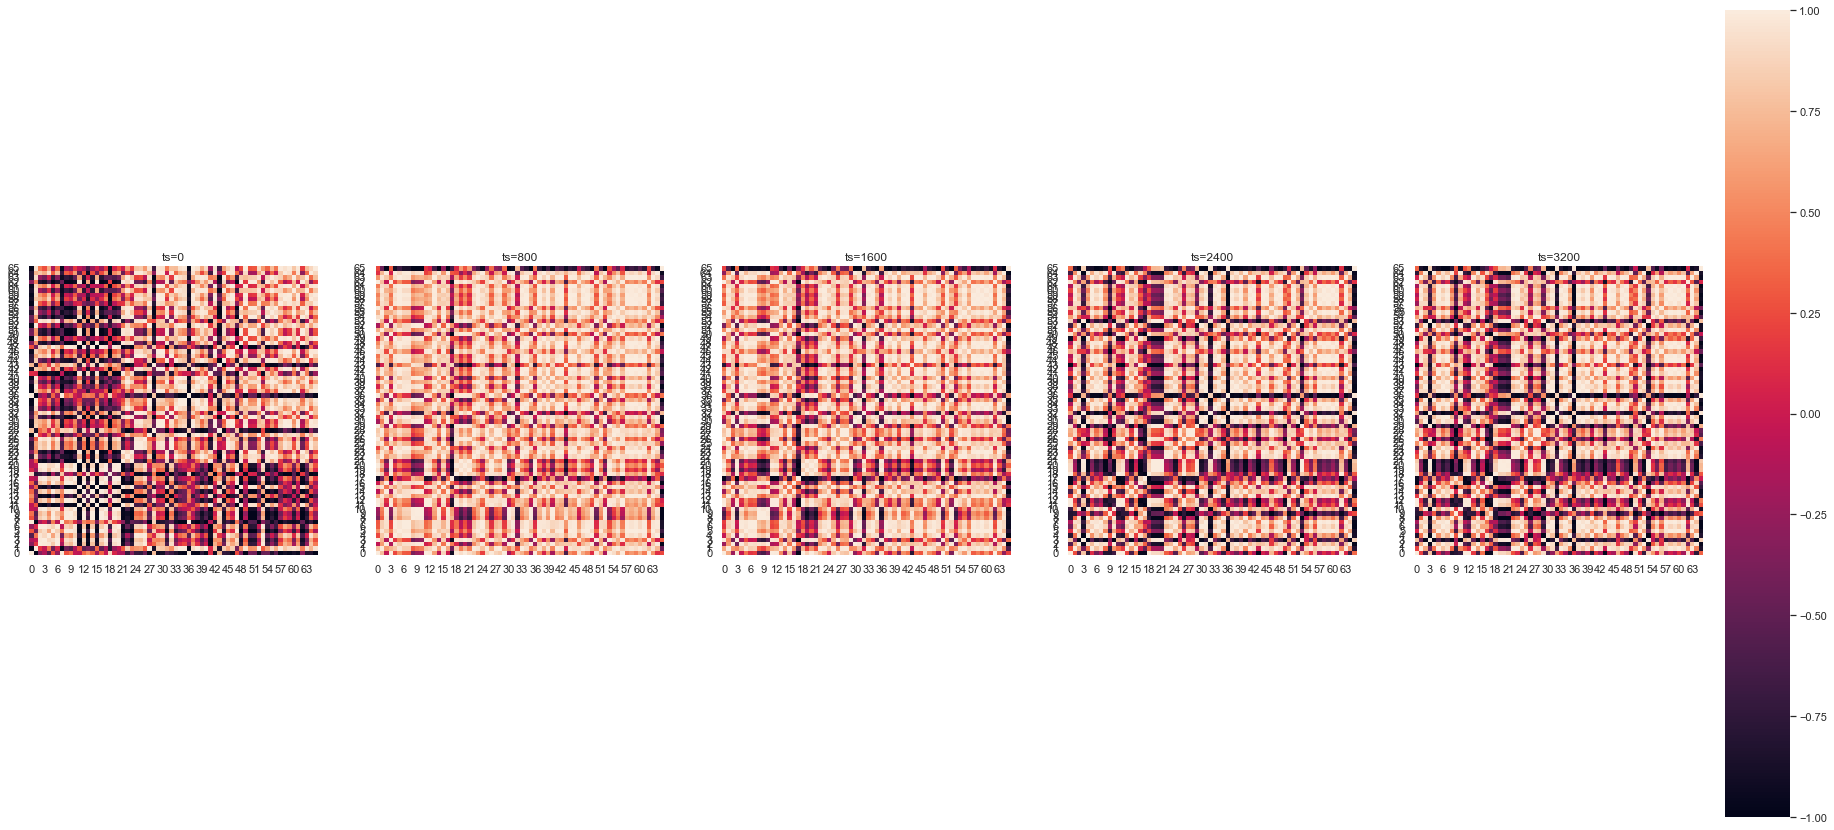

In [49]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,799].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,2399].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,3199].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=800')
axs[2].title.set_text('ts=1600')
axs[3].title.set_text('ts=2400')
axs[4].title.set_text('ts=3200')

In [36]:
T=320
num_points = 6400
smooth_omega = np.zeros((N,1,T))
smooth_A = np.zeros((N,N,T))
for t in range(0,int(T/16)):
    smooth_omega[:,:,t] = ((T/16-1-t)/(T/16-1))*omega[:,:,0]+ (t/(T/16-1))*omega[:,:,1]
    smooth_A[:,:,t] = ((T/16-1-t)/(T/16-1))*SCMatrix+ (t/(T/16-1))*StableSC[:,:,0]
for t in range(int(T/16),int(T/2)):
    smooth_omega[:,:,t] = omega[:,:,1]
    smooth_A[:,:,t]=StableSC[:,:,0]
for t in range(int(T/2),int(T/16 + T/2)):
    smooth_omega[:,:,t] = ((T/16-1-t)/(T/16-1))*omega[:,:,1]+ (t/(T/16-1))*omega[:,:,2]
    smooth_A[:,:,t] = ((T/16-1-t)/(T/16-1))*StableSC[:,:,0]+ (t/(T/16-1))*StableSC[:,:,1]
for t in range(int(T/16 + T/2),int(T)):
    smooth_omega[:,:,t] = omega[:,:,2]
    smooth_A[:,:,t]=StableSC[:,:,1]     
#sol,t = KFB.SolveKuramotoModeTDFrequencyAdj(EstimatedPhases[:,0],T,N,smooth_omega[:,0,:]+0.29,smooth_A,num_points)

In [11]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

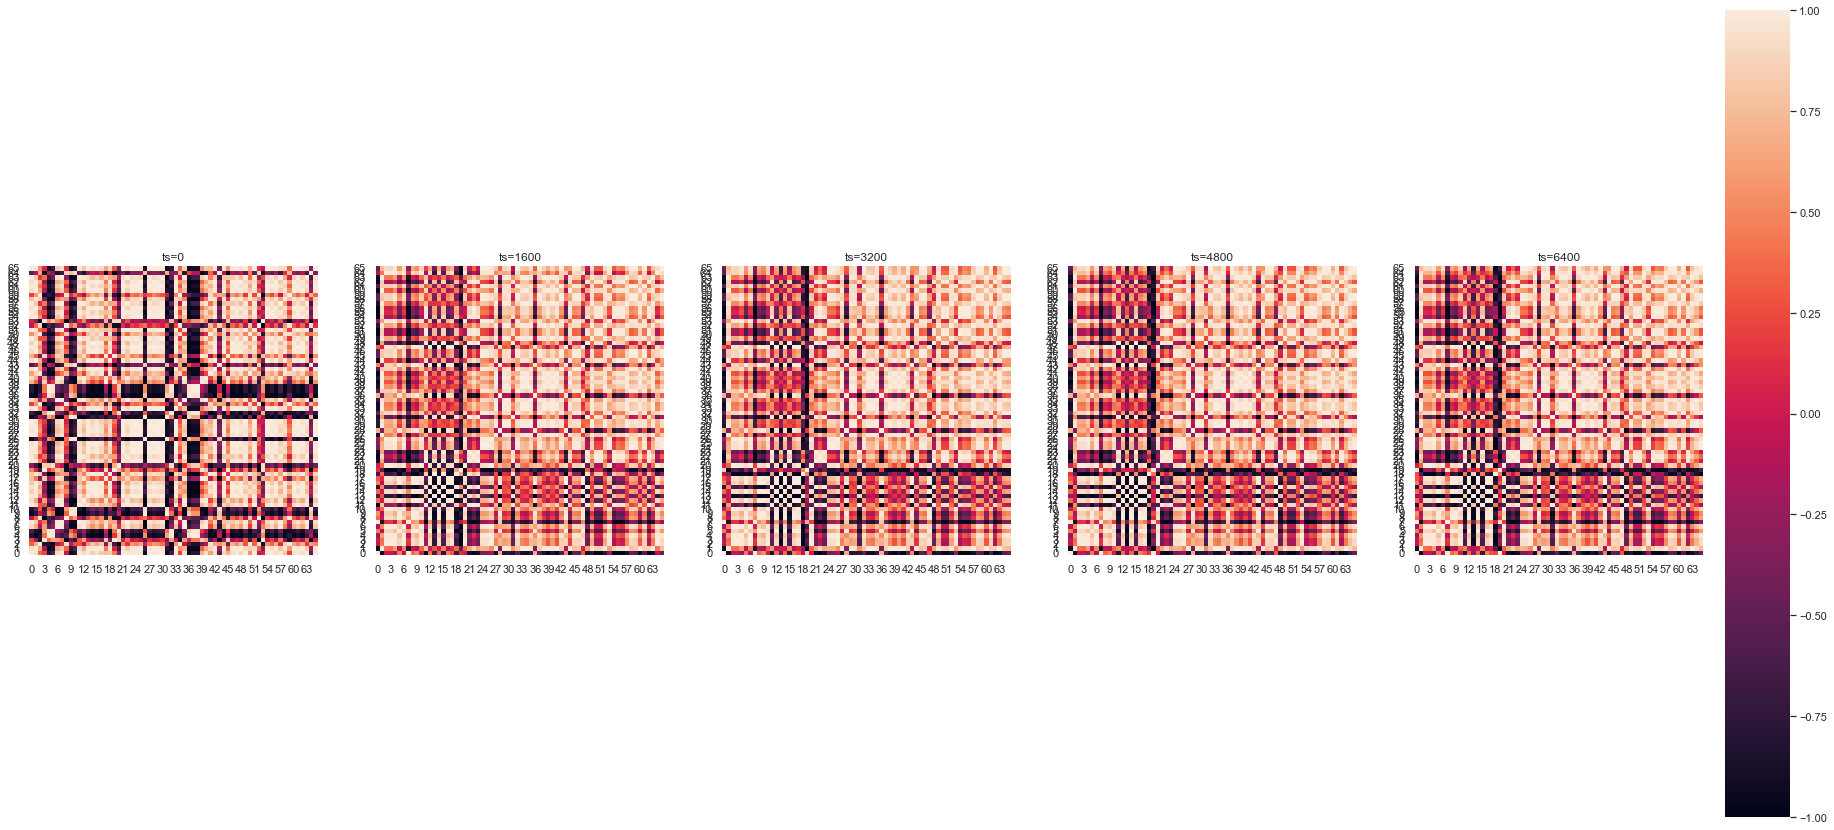

In [12]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,3199].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,4799].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,6399].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=1600')
axs[2].title.set_text('ts=3200')
axs[3].title.set_text('ts=4800')
axs[4].title.set_text('ts=6400')

In [32]:
startpointfor23 = sol[3200,:]

In [19]:
np.sin(EstimatedPhases[:,1])

array([-0.97062654,  0.9980297 ,  0.08763399, -0.10819521,  0.35257046,
       -0.5009182 ,  0.01556437, -0.99800596, -0.48892569, -0.60759137,
       -0.202272  ,  0.31401198, -0.56983549, -0.30683768, -0.56037093,
        0.41373618, -0.55553234, -0.20689362, -0.75321407, -0.30548832,
       -0.10230145,  0.37025792,  0.86334364,  0.54082913,  0.51334068,
        0.55322427,  0.24493934,  0.99821863, -0.90100979,  0.82074996,
        0.76099388,  0.74297894,  0.48014216,  0.93597437,  0.99984287,
        0.99013655, -0.9842198 ,  0.87608535,  0.99974169,  0.88055349,
        0.99670335,  0.13950461,  0.778754  , -0.87360328,  0.86465726,
        0.58419511,  0.81440386, -0.47060498,  0.57436199,  0.92213211,
        0.59831443,  0.62111924,  0.99916333,  0.25043042,  0.66228126,
        0.93712633,  0.72603648,  0.97560784,  0.76136292,  0.87703495,
        0.96246041,  0.84999165,  0.53147272,  0.94456007,  0.66541966,
        0.93286589])

In [69]:
T=320
num_points = 6400
smooth_omega = np.zeros((N,1,T))
smooth_A = np.zeros((N,N,T))
for t in range(0,int(T/16)):
    smooth_omega[:,:,t] = ((T/16-1-t)/(T/16-1))*omega[:,:,0]+ (t/(T/16-1))*omega[:,:,1]
    smooth_A[:,:,t] = ((T/16-1-t)/(T/16-1))*SCMatrix+ (t/(T/16-1))*StableSC[:,:,0]
for t in range(int(T/16),int(T/2)):
    smooth_omega[:,:,t] = omega[:,:,1]
    smooth_A[:,:,t]=StableSC[:,:,0]
for t in range(0,int(T/16)):
    smooth_omega[:,:,t+int(T/2)] = ((T/16-1-t)/(T/16-1))*omega[:,:,1]+ (t/(T/16-1))*omega[:,:,2]
    smooth_A[:,:,t+int(T/2)] = ((T/16-1-t)/(T/16-1))*StableSC[:,:,0]+ (t/(T/16-1))*SCMatrix
for t in range(0,int(T/16)):
    smooth_omega[:,:,t+int(T/2)+int(T/16)] = omega[:,:,2]
    smooth_A[:,:,t+int(T/2)+int(T/16)] = ((T/16-1-t)/(T/16-1))*SCMatrix+ (t/(T/16-1))*StableSC[:,:,1]
for t in range(int(T/8),int(T/2)):
    smooth_omega[:,:,t+int(T/2)] = omega[:,:,2]
    smooth_A[:,:,t+int(T/2)]=StableSC[:,:,1]     
#sol,t = KFB.SolveKuramotoModeTDFrequencyAdj(EstimatedPhases[:,0],T,N,smooth_omega[:,0,:]+0.29,smooth_A,num_points)

In [70]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

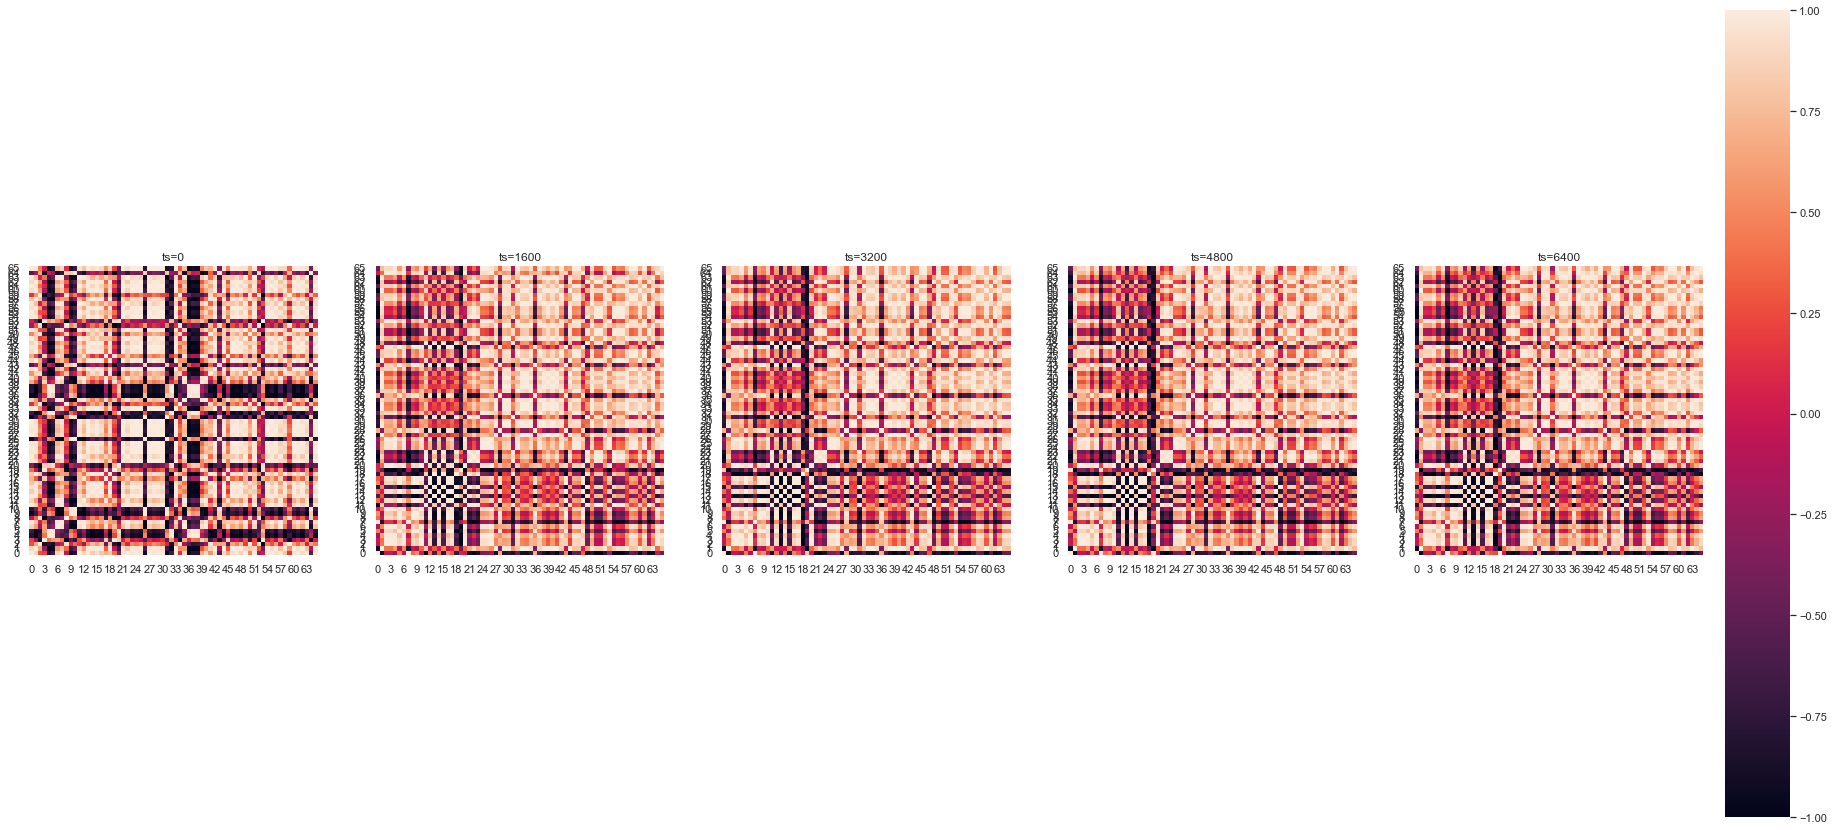

In [71]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,3199].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,4799].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,6399].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=1600')
axs[2].title.set_text('ts=3200')
axs[3].title.set_text('ts=4800')
axs[4].title.set_text('ts=6400')

## Stability and structural balance of cosine scaled networks

A functional pattern in conjunction with the structural connectome induces a signed graph. The stability of the functional pattern can be partially determined by the structural balance of this signed graph. We can implement an algorithm to evaluate the structural balance of this signed graph.

In [164]:
#Build some toy graphs to test algorithm on

signed1 = np.array([[0,1,1,0,0,0,0,0,0,0,0,0,0,0,0],[1,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],[1,1,0,0,0,-1,0,0,0,0,0,0,0,0,0],[0,-1,0,0,0,0,-1,0,-1,0,0,0,0,0,0],[0,1,0,0,0,-1,0,0,0,0,0,0,0,0,0],[0,0,-1,0,-1,0,0,1,0,0,-1,0,0,0,0],[0,0,0,-1,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,1,0,0,0,0,-1,0,0,0,0],[0,0,0,-1,0,0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0],[0,0,0,0,0,-1,0,-1,0,-1,0,0,-1,-1,0],[0,0,0,0,0,0,1,0,1,1,0,0,1,0,0],[0,0,0,0,0,0,0,0,0,0,-1,1,0,0,-1],[0,0,0,0,0,0,0,0,0,0,-1,0,0,0,-1],[0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,0]])
balance = KFB.DetermineStructuralBalance(signed1)
print(balance)

False


In [197]:
pos_edges, neg_edges = KFB.CalculateSignedEdgeSet(signed1)
pos_adj = KFB.CalculateAdjFromEdges(pos_edges,15)
pos_cc = KFB.CalculateConnectedComponents(pos_adj)
KFB.CheckForNegEdgesSuperNode(pos_cc,neg_edges)
super_neg_adj = KFB.CalculateSuperNegAdj(pos_cc,neg_edges)
super_neg_edges = KFB.CalculateEdgeSet(super_neg_adj)
layers = KFB.ExtractLayersFromSuperNegGraph(super_neg_adj)
balance = KFB.CheckBalanceFromLayers(layers,super_neg_adj)

Given a functional pattern and the structural connectome, we should be able to find a given signed network. We can then check the structural balance of this network to determine the stability of this functional pattern

In [224]:
SignedNetworks = np.zeros((N,N,E))
for i in range(0,E):
    SignedNetworks[:,:,i]= KFB.CalculateSignedNetwork(SCMatrix,x_desired[:,i],edges)
    print(KFB.DetermineStructuralBalance(SignedNetworks[:,:,i]))

False
False
False
False
False


Functional patterns that induce structurally balanced cosine scaled networks are unstable, but none of these functional patterns fulfill that criteria. So what does that mean, are they stable or not?!

Instead we can explicitly calculate the Jacobian and its eigenvalues for each functional pattern

In [257]:
J = np.zeros((N,N,E))
for i in range(0,E):
    DD = KFB.CalculateWeightedCosineMatrix(SignedNetworks[:,:,i],edges)
    J[:,:,i] = -np.matmul(B,np.matmul(DD, B.T))
    print('Max eigenvalue ' + str(np.max(np.linalg.eig(J[:,:,i])[0])))
    print('Number of positive eigenvalues ' + str(len(list(filter(lambda x: (x>=0),np.linalg.eig(J[:,:,i])[0])))))

Max eigenvalue 1.5387180183289748
Number of positive eigenvalues 13
Max eigenvalue 0.8200961577987169
Number of positive eigenvalues 12
Max eigenvalue 1.0343984637323391
Number of positive eigenvalues 16
Max eigenvalue 0.49663641106007983
Number of positive eigenvalues 11
Max eigenvalue 0.6617394457112692
Number of positive eigenvalues 14


All functional patterns yield Jacobians with positive eigenvalues - hence the instability. Lets look now at the networks and Jacobians induced by the heuristic approach to stability.

In [20]:
StableSignedNetworks = np.zeros((N,N,E-1))
StableEdges =[]
for i in range(0,E-1):
    StableEdges.append(KFB.CalculateEdgeSet(StableSC[:,:,i]))
for i in range(0,E-1):
    StableSignedNetworks[:,:,i]= KFB.CalculateSignedNetwork(StableSC[:,:,i],x_desired[:,i],StableEdges[i])
    print(KFB.DetermineStructuralBalance(StableSignedNetworks[:,:,i]))

False
False
False
False


In [31]:
StableJ = np.zeros((N,N,E-1))
StableIncidence = []
for i in range(0,E-1):
    DD = KFB.CalculateWeightedCosineMatrix(StableSignedNetworks[:,:,i],StableEdges[i])
    StableIncidence.append(KFB.CalculateIncidenceMatrix(StableEdges[i],N))
    StableJ[:,:,i] = -np.matmul(StableIncidence[i],np.matmul(DD,StableIncidence[i].T))
    print('Max eigenvalue ' + str(np.max(np.linalg.eig(StableJ[:,:,i])[0])))
    print('Number of positive eigenvalues ' + str(len(list(filter(lambda x: (x>=0),np.linalg.eig(StableJ[:,:,i])[0])))))

Max eigenvalue 0.9495704270995877
Number of positive eigenvalues 15
Max eigenvalue 0.933828199274503
Number of positive eigenvalues 16
Max eigenvalue 0.9840715913455493
Number of positive eigenvalues 15
Max eigenvalue 0.40211405125854033
Number of positive eigenvalues 12


So the heuristic approach does not moved the eigenvalues into the left half plane as claimed. But it reduces the value of the largest positive eigenvalue in 3/4 cases. It seems to increase the number of positive eigenvalues so I am not sure if I have made a mistake or if the heurisitic approach is truly useless in this case. Yet it somehow seems to improve stability. The method is definitely heuristic and so does not gurantee stability, but somehow it promotes the transition between these states i.e. it works to a certain extent but I am not sure why.

In [111]:
T=320
t_0=160
num_points = 3200
smooth_omega_2 = np.zeros((N,1,T))
smooth_A_2 = np.zeros((N,N,T))
for t in range(0,int(T/8)):
    smooth_omega_2[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*omega[:,:,1]+ (t/(0.125*T-1))*omega[:,:,2]
    smooth_A_2[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*StableSC[:,:,0]+ (t/(0.125*T-1))*StableSC[:,:,1]
for t in range(int(T/8),T):
    smooth_omega_2[:,:,t] = omega[:,:,2]
    smooth_A_2[:,:,t]=StableSC[:,:,1]
sol,t = KFB.SolveKuramotoModelTDFrequencyAdj(startpointfor23,T,N,smooth_omega_2[:,0,:]+0.29,smooth_A_2,num_points,t_0)

In [114]:
t

array([160.        , 160.05001563, 160.10003126, ..., 319.89996874,
       319.94998437, 320.        ])

In [112]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

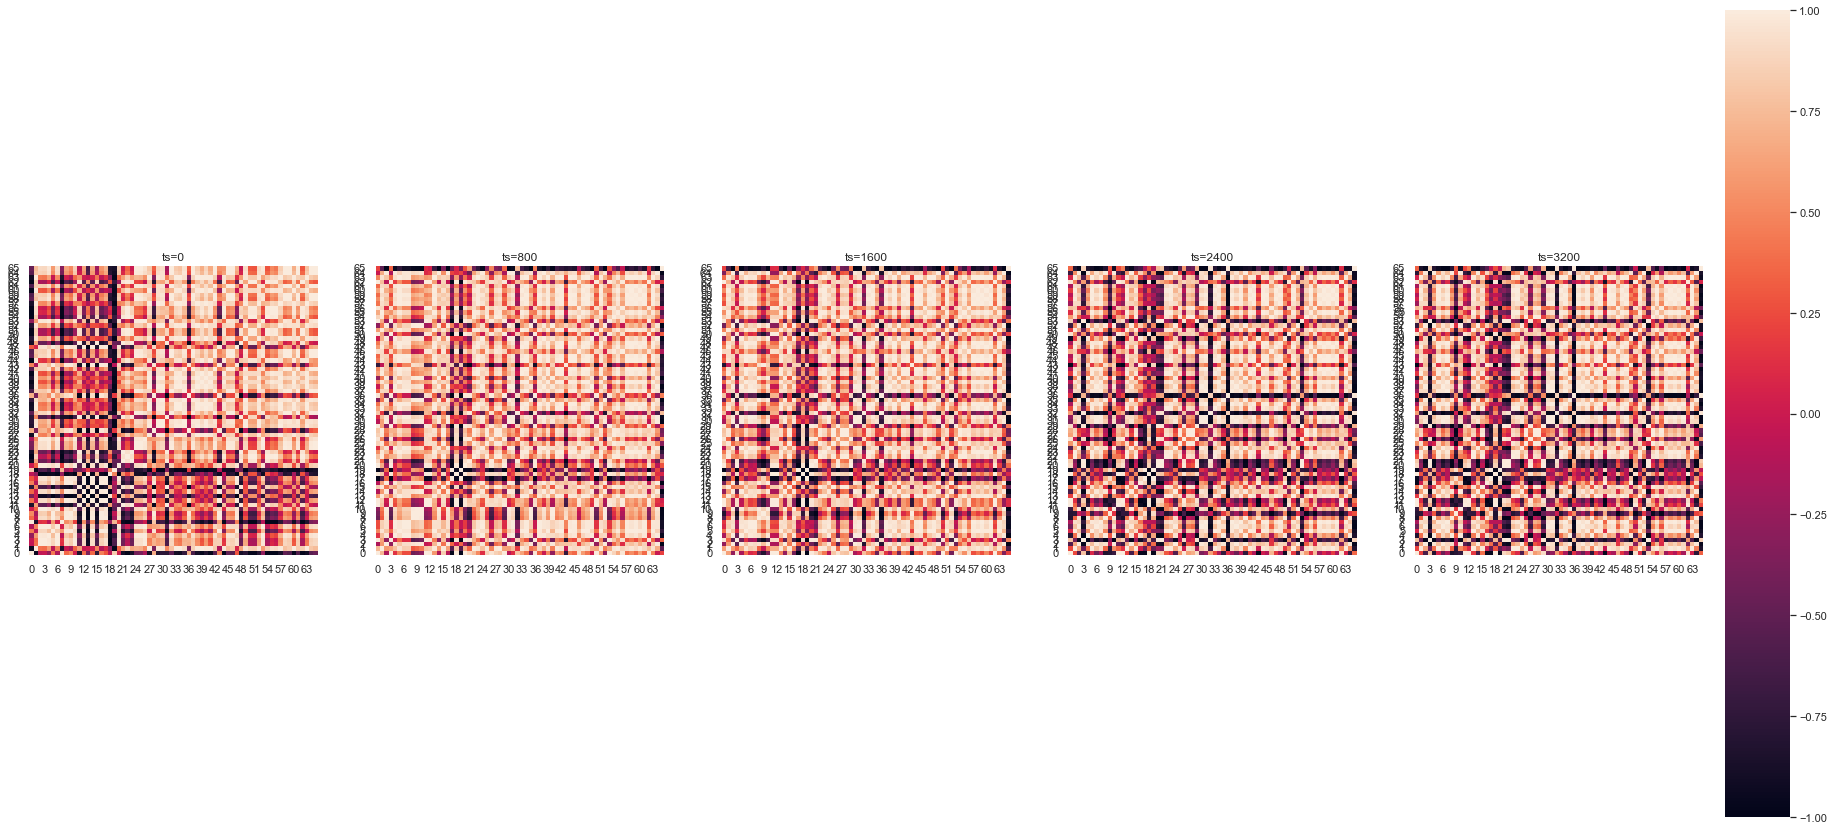

In [113]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,799].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,2399].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,3199].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=800')
axs[2].title.set_text('ts=1600')
axs[3].title.set_text('ts=2400')
axs[4].title.set_text('ts=3200')

This is very confusing. In the above simulation, I extracted the state that the (attempted) three pattern simulation was in and then used it as an initial condition for an attempted transition between 2 and 3 and it worked. In other words, runnning an identical simulation in 2 parts works whereas running it all together does not. I am not sure why this could be happening.

In [118]:
T=160
num_points = 6400
smooth_omega12 = np.zeros((N,1,T))
smooth_A12 = np.zeros((N,N,T))
smooth_omega23 = np.zeros((N,1,T))
smooth_A23 = np.zeros((N,N,T))

smooth_A=np.zeros((N,N,2*T))
smooth_omega = np.zeros((N,1,2*T))

for t in range(0,int(T/8)):
    smooth_omega12[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*omega[:,:,0]+ (t/(0.125*T-1))*omega[:,:,1]
    smooth_A12[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*SCMatrix+ (t/(0.125*T-1))*StableSC[:,:,0]
for t in range(int(T/8),T):
    smooth_omega12[:,:,t] = omega[:,:,1]
    smooth_A12[:,:,t]=StableSC[:,:,0]
for t in range(0,int(T/8)):
    smooth_omega23[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*omega[:,:,1]+ (t/(0.125*T-1))*omega[:,:,2]
    smooth_A23[:,:,t] = ((0.125*T-1-t)/(0.125*T-1))*StableSC[:,:,0]+ (t/(0.125*T-1))*StableSC[:,:,1]
for t in range(int(T/8),T):
    smooth_omega23[:,:,t] = omega[:,:,2]
    smooth_A23[:,:,t]=StableSC[:,:,1]

smooth_A[:,:,0:160] = smooth_A12
smooth_A[:,:,160:320] = smooth_A23
smooth_omega[:,:,0:160] = smooth_omega12
smooth_omega[:,:,160:320] = smooth_omega23

In [119]:
sol,t = KFB.SolveKuramotoModelTDFrequencyAdj(EstimatedPhases[:,0],2*T,N,smooth_omega[:,0,:]+0.29,smooth_A,num_points,0)

In [121]:
sol2[1,:]-sol[3201,:]

array([ 3.43948739e-02, -3.52272650e-02, -7.55840617e-03, -2.28653130e-02,
        4.65502587e-03,  5.52741783e-02,  3.93440597e-05,  2.34644899e-02,
       -1.49114735e-02,  4.94516423e-02, -3.31115272e-03,  1.02027626e-02,
        8.10377328e-04, -3.86005753e-02, -1.03953276e-02, -2.65144194e-02,
        4.43794522e-03,  1.03018914e-02, -1.23299270e-02,  7.19398642e-03,
        2.59590269e-02, -9.28150351e-03, -7.97559859e-03, -8.29341704e-03,
       -7.84231473e-03,  1.32263588e-02, -4.69677310e-03, -4.66978462e-04,
        4.37849435e-03, -3.21938619e-02, -1.91627719e-03, -3.81951531e-03,
        1.83921570e-02, -5.49898403e-03, -5.43496701e-02,  1.89099675e-02,
        7.94300604e-02,  1.85546346e-03, -6.46129590e-03,  2.71194387e-03,
        1.34166458e-02, -1.92701379e-02,  1.39677882e-02,  7.50620671e-03,
       -8.74860060e-03, -1.35611342e-02,  8.45000571e-03,  3.20359619e-02,
       -3.10098421e-02, -5.18152297e-04, -1.96340943e-02,  2.68268184e-03,
       -9.75251013e-03, -

In [122]:
#Complete identical steps to in previous cases to extract F matrices for every time step
Cos_Phase_Differences = np.zeros((N,N,num_points))
Phase_Differences = np.zeros((N,N,num_points))
for i in range(0,num_points):
    for j in range(0,N):
        for k in range(0,N):
            Cos_Phase_Differences[j][k][i] = np.cos(sol[i][k]-sol[i][j])
            Phase_Differences[j][k][i] = sol[i][k]-sol[i][j]

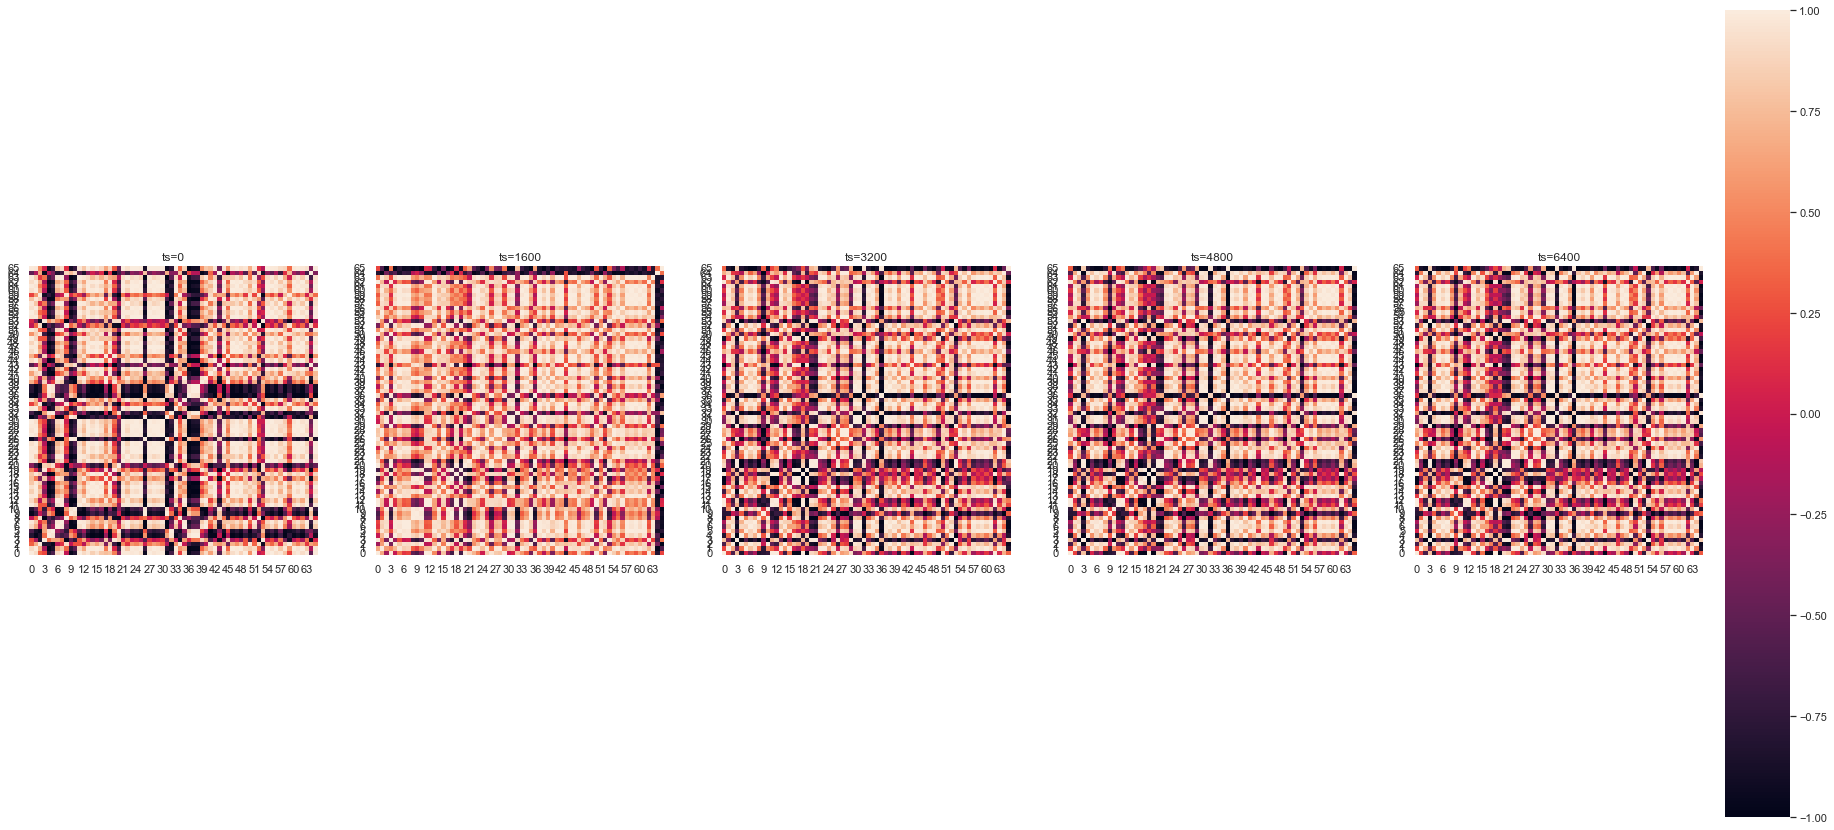

In [106]:
sns.set(rc={'figure.figsize':(30,16)})

fig, axs = plt.subplots(1,5)
cbar_ax = fig.add_axes([.91, .15, .03, .7])
axs[0]= sns.heatmap(Cos_Phase_Differences[:,:,0].T,ax=axs[0],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[0].invert_yaxis()
axs[1]= sns.heatmap(Cos_Phase_Differences[:,:,1599].T,ax=axs[1],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[1].invert_yaxis()
axs[2]= sns.heatmap(Cos_Phase_Differences[:,:,3199].T,ax=axs[2],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[2].invert_yaxis()
axs[3]= sns.heatmap(Cos_Phase_Differences[:,:,4799].T,ax=axs[3],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[3].invert_yaxis()
axs[4]= sns.heatmap(Cos_Phase_Differences[:,:,6399].T,ax=axs[4],square=True,vmin=-1,vmax=1,cbar_ax=cbar_ax)
axs[4].invert_yaxis()
axs[0].title.set_text('ts=0')
axs[1].title.set_text('ts=1600')
axs[2].title.set_text('ts=3200')
axs[3].title.set_text('ts=4800')
axs[4].title.set_text('ts=6400')

There is a difference in the numerical integration when running the simulation in parts or all together. I do not know how to explain this difference but I do not think it is very important. It just limits the natural transitioning between the functional patterns. 

I thought it might be the time vector but it is not that either. That also seems to work. So I am not at all sure why running the simulation once and then running it again from the exact start point yet running it through does not yield thate same result, it could be down to floating point errors as these are seen in the outputs. However, susceptibility to tiny floating point errors makes this a very non-robust approach.